# Mini-projet n° 4 – RNN, LSTM and GRU vs MLP and CNN

## Importation des librairies

In [17]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# text processing
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stopwords = set(stopwords.words('english'))

# pytorch
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

# sklearn
from sklearn.metrics import classification_report, confusion_matrix

# utils
import os
from tqdm import tqdm
tqdm.pandas()
from collections import Counter
import optuna

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rabasquinho/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/rabasquinho/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/rabasquinho/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Les sources suivantes ont été utilisées pour réaliser ce projet :

- Affandy Fahrizain. IMDB with PyTorch. kaggle. https://www.kaggle.com/code/affand20/imdb-with-pytorch. 2021
- Patrick Loeber . PyTorch Tutorial - RNN & LSTM & GRU - Recurrent Neural Nets. Python Engineer. https://www.python-engineer.com/posts/pytorch-rnn-lstm-gru/. 2020

## Chargement et étude préliminaire du jeu de données

L'objectif du projet est de réussir à obtenir un modèle efficace permettant de prédire si un commentaire laissé en ligne par un spectateur ayant vu un film est une critique positive ou négative de ce film. Pour cela on veut comparer les performances prédictives de 5 modèles différents : 
- 3 types de RNN (Recurrent Neural Network) : un RNN "classique", un LSTM (Long Short-Terme Memory) et un GRU (Gated Recurrent Unit)
- un CNN (Convolutionnal Neural Netowork) 
- un MLP (MultiPerceptron Layer)

In [2]:
data = pd.read_csv('data/IMDB Dataset.csv')

On transforme ensuite les labels des classes (ou sentiment) qui sont des chaînes de caractères en valeurs numériques. Le label "positive" ou "négative" renvoie à la critique des spectateurs ayant vu le film et ayant laissé un commentaire. Un sentiment "positif" sera associé au label 1 tandis qu'un sentiment négatif sera associé au label 0.

In [3]:
def transform_label(label):
    return 1 if label == 'positive' else 0

data['label'] = data['sentiment'].progress_apply(transform_label)
data.head()

100%|██████████| 50000/50000 [00:00<00:00, 911860.72it/s]


,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [4]:
data.sentiment.value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

On remarque que le jeu de données est équilibré : la moitié des films ont reçu des critiques "positives" et l'autre moitié des critiques "négatives".

In [5]:
data['token_length'] = data.review.progress_apply(lambda x: len(x.split()))

100%|██████████| 50000/50000 [00:00<00:00, 77086.64it/s]


In [6]:
data_pos = data[data['label'] == 1]
data_pos['token_length'].describe()

count    25000.000000
mean       232.849320
std        177.497046
min         10.000000
25%        125.000000
50%        172.000000
75%        284.000000
max       2470.000000
Name: token_length, dtype: float64

On s'intéresse ici à la longueur des commentaires positifs. En moyenne elle est d'environ 233 tokens et varie de 10 à 2470 tokens. Un token, on le verra par la suite, désigne en fait un mot, un symbole de ponctuation ou tout autre symbole spécial.

In [7]:
data_neg = data[data['label'] == 0]
data_neg['token_length'].describe()

count    25000.000000
mean       229.464560
std        164.947795
min          4.000000
25%        128.000000
50%        174.000000
75%        278.000000
max       1522.000000
Name: token_length, dtype: float64

En répétant le même processus pour les commentaires négatifs, on constate que la moyenne des commentaires négatifs, ainsi que les premier, deuxième et troisième quartiles ont des longueurs proches de celles des commentaires positifs. Le nombre de tokens ne semble donc pas influencer le type de commentaires (positifs ou négatifs). On le visualise aisément sur le boxplot suivant :

/tmp/ipykernel_6506/127678021.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment', y='token_length', data=data, palette='Set2')


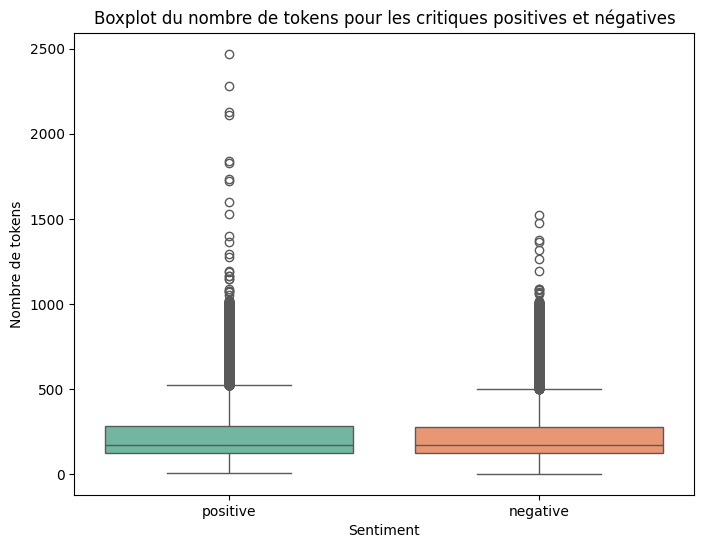

In [8]:
# Création du boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='sentiment', y='token_length', data=data, palette='Set2')

plt.title('Boxplot du nombre de tokens pour les critiques positives et négatives')
plt.xlabel('Sentiment')
plt.ylabel('Nombre de tokens')

plt.show()

On peut également visualiser quelques exemples de commentaires positifs et négatifs.

In [9]:
# Exemples de commentaires positifs
print('Positive')
print(data_pos[data_pos['token_length'] == data_pos['token_length'].min()]['review'].item())
print(data_pos[data_pos['token_length'] == data_pos['token_length'].min() + 2]['review'].item())
print(data_pos[data_pos['token_length'] == data_pos['token_length'].min() + 4]['review'].item())
print()

# Exemples de commentaires négatifs
print('Negative')
print(data_neg[data_neg['token_length'] == data_neg['token_length'].min()]['review'].item())
print(data_neg[data_neg['token_length'] == data_neg['token_length'].min() + 2]['review'].item())
print(data_neg[data_neg['token_length'] == data_neg['token_length'].min() + 5]['review'].item())

Positive
Brilliant and moving performances by Tom Courtenay and Peter Finch.
Adrian Pasdar is excellent is this film. He makes a fascinating woman.
This is a great movie. Too bad it is not available on home video.

Negative
Primary plot!Primary direction!Poor interpretation.
Read the book, forget the movie!
What a script, what a story, what a mess!


# Nettoyage du texte

## Séléction des caractères conservés

L'objectif de cette section est de retirer tous les éléments des textes pouvant être présents mais que l'on ne juge pas utiles d'exploiter pour détecter la nature du commentaire. <br>
Par exemple "\<b\> I loooove this movie !!! 😁 \<b\>" devient "I love this movie !"

In [10]:
def rm_link(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text) # supprime les liens url

def rm_punct(text):
    # supprime des signes de ponctuation spécifiques (mais . ! et ? sont conservés par exemple)
    return re.sub(r'[\"\#\$\%\&\'\(\)\*\+\/\:\;\<\=\>\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)

def rm_html(text):
    return re.sub(r'<[^>]+>', '', text) # supprime les balises html

def space_bt_punct(text):
    pattern = r'([.,!?-])'
    s = re.sub(pattern, r' \1 ', text) # ajoute des espaces entre la ponctuation et les mots
    s = re.sub(r'\s{2,}', ' ', text) # enleve les doubles espaces
    return s

def rm_number(text):
    return re.sub(r'\d+', '', text) # supprime les chiffres

def rm_whitespaces(text):
    return re.sub(r' +', ' ', text) # supprime les espaces excédentaires

def rm_nonascii(text):
    return re.sub(r'[^\x00-\x7f]', r'', text) # supprime les caracteres non ASCII

def rm_emoji(text):
    # supprime les emojis
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'
        u'\U0001F300-\U0001F5FF'
        u'\U0001F680-\U0001F6FF'
        u'\U0001F1E0-\U0001F1FF'
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    return emojis.sub(r'', text)

def spell_correction(text):
    return re.sub(r'(.)\1+', r'\1\1', text) # supprime les repetitions de lettres consecutives (de sorte à en laisser au plus 2)

def clean_pipeline(text):    
    no_link = rm_link(text)
    no_html = rm_html(no_link)
    space_punct = space_bt_punct(no_html)
    no_punct = rm_punct(space_punct)
    no_number = rm_number(no_punct)
    no_whitespaces = rm_whitespaces(no_number)
    no_nonasci = rm_nonascii(no_whitespaces)
    no_emoji = rm_emoji(no_nonasci)
    spell_corrected = spell_correction(no_emoji)
    return spell_corrected

## Transformation en tokens

Pour transformer notre texte en tokens, il existe différentes possibilités. Ici le choix a été fait d'un découpage "mot par mot" via la fonction word_tokenize, c'est-à-dire que chaque token est assimilé à un mot du texte. <br>
De plus, les "stopwords" c'est-à-dire les mots n'apportant pas un sens significatif au texte (ex : "the", "at", "and"...), sont retirés du texte et chaque mot est récupéré sous une forme simplifiée appelée forme "canonique" (ex : "running", "runs" et "runner" deviennent "run"). <br>
Ainsi, par exemple la séquence ['The', 'men', 'are', 'fighting'] est récupérée sous la forme "men fight".

In [11]:
def tokenize(text):
    return word_tokenize(text)

def rm_stopwords(text):
    return [i for i in text if i not in stopwords] # élimine les "stopwords"

def lemmatize(text):
    lemmatizer = WordNetLemmatizer() # récupère chaque mot dans sa forme "canonique"
    lemmas = [lemmatizer.lemmatize(t) for t in text] # à nouveau élimination des "stopwords"
    return rm_stopwords(lemmas)

def preprocess_pipeline(text):
    tokens = tokenize(text)
    no_stopwords = rm_stopwords(tokens)
    lemmas = lemmatize(no_stopwords)
    return ' '.join(lemmas)

In [ ]:
data['clean'] = data['review'].progress_apply(clean_pipeline) # après nettoyage du texte
data['processed'] = data['clean'].progress_apply(preprocess_pipeline) # après tokenization

# Encodage des textes

Pour la suite, pour réaliser la prédiction de classe, on ne conserve que les textes prétraîtés ainsi que leurs labels.

In [3]:
data_pred = pd.read_csv('data/IMDB_Pred.csv') # data précédent avec uniquement les colonnes processed et label
data_pred.head()

,processed,label
0,One reviewer mentioned watching Oz episode hoo...,1
1,A wonderful little production . The filming te...,1
2,I thought wonderful way spend time hot summer ...,1
3,Basically family little boy Jake think zombie ...,0
4,Petter Mattei Love Time Money visually stunnin...,1


Puisque dans notre étude un mot est associé à un token, il est nécessaire de trouver une méthode de codage de chacun de ces tokens, c'est-à-dire leur affecter une valeur numérique (de sorte à ce qu'un même mot ait toujours le même "numéro de token").

Pour cela, on commence par extraire toutes les critiques (que l'on vient de prétraiter), on les fusionne en une seule chaîne de texte, puis on les divise en mots individuels. <br>
On crée ensuite un vocabulaire en comptant la fréquence des mots, puis en triant les mots par fréquence. Le mot le plus fréquent parmi toutes les critiques se verra donc affecter la valeur numérique la plus basse parmi les tokens, et le mot le moins présent parmi tous les textes la valeur la plus élevée. On génère alors deux dictionnaires : 

- int2word : associe un entier (index) à chaque mot.
- word2int : associe chaque mot à son index.

In [4]:
texts = data_pred.processed.values 
words = ' '.join(texts) # fusionne tous les textes en un seul

words = words.split() # recupère la liste de tous les mots

words[:100]

['One',
 'reviewer',
 'mentioned',
 'watching',
 'Oz',
 'episode',
 'hooked',
 '.',
 'They',
 'right',
 ',',
 'exactly',
 'happened',
 '.',
 'The',
 'first',
 'thing',
 'struck',
 'Oz',
 'brutality',
 'unflinching',
 'scene',
 'violence',
 ',',
 'set',
 'right',
 'word',
 'GO',
 '.',
 'Trust',
 ',',
 'show',
 'faint',
 'hearted',
 'timid',
 '.',
 'This',
 'show',
 'pull',
 'punch',
 'regard',
 'drug',
 ',',
 'sex',
 'violence',
 '.',
 'Its',
 'hardcore',
 ',',
 'classic',
 'use',
 'word',
 '.',
 'It',
 'called',
 'OZ',
 'nickname',
 'given',
 'Oswald',
 'Maximum',
 'Security',
 'State',
 'Penitentary',
 '.',
 'It',
 'focus',
 'mainly',
 'Emerald',
 'City',
 ',',
 'experimental',
 'section',
 'prison',
 'cell',
 'glass',
 'front',
 'face',
 'inwards',
 ',',
 'privacy',
 'high',
 'agenda',
 '.',
 'Em',
 'City',
 'home',
 'many',
 '.',
 '.',
 'Aryans',
 ',',
 'Muslims',
 ',',
 'gangsta',
 ',',
 'Latinos',
 ',',
 'Christians',
 ',',
 'Italians']

In [5]:
# Création des dictionnaires
counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True) # trie les mots par fréquence décroissante
int2word = dict(enumerate(vocab, 1))
int2word[0] = '<PAD>'
word2int = {word: id for id, word in int2word.items()}

Maintenant que notre dictionnaire est créé, on peut encoder chacun des textes.

In [6]:
texts_enc = [[word2int[word] for word in review.split()] for review in tqdm(texts)]

# Affichage des 10 premiers encodages des 3 premiers textes
for i in range(3):
    print(texts_enc[i][:10])

100%|██████████| 50000/50000 [00:01<00:00, 28598.03it/s]

[191, 1083, 930, 81, 3722, 186, 3030, 1, 118, 114]
[47, 328, 59, 244, 1, 7, 1267, 1608, 17880, 4]
[3, 95, 328, 30, 1041, 13, 845, 1774, 2633, 2]


Enfin, pour les modèles de RNN avec lesquels on souhaite ensuite travailler pour réaliser notre prédiction, il est nécessaire que toutes nos entrées soient de même taille. Or, nous l'avons vu au début de l'étude, on dispose de textes de taille différentes. Il est donc nécessaire de fixer une taille "standard" des entrées : pour les critiques "plus courtes" on fait du padding (c'est-à-dire qu'on complète la séquence avec un identifiant spécial \<PAD\>) et pour celles "plus longues", la séquence est tronquée.

Pour le choix de la taille standard, il vaut mieux une valeur qui limite le nombre de textes tronqués, tout en restreignant la taille totale des séquences. Souvent, pour des réseaux tels que des LSTM ou GRU, la taille des séquences utilisées est de 128 ou 256. Ici, en prenant une taille de 256, on se rend compte qu'une grande majorité des séquences n'aura pas à être tronquée. Ce sera uniquement le cas des séquences excessivement longues (avec notamment 1721 tokens pour la plus longue séquence).

In [7]:
# Calcul des longueurs des revues
texts_lengths = [len(review.split()) for review in texts]

# Calcul de la moyenne et de la médiane
avg_length = np.mean(texts_lengths)
median_length = np.median(texts_lengths)
max_length = np.max(texts_lengths)

# Affichage des résultats
print(f"Longueur moyenne des textes : {avg_length}")
print(f"Longueur médiane des textes : {median_length}")
print(f"Longueur maximale des textes : {max_length}")

Longueur moyenne des textes : 157.7677
Longueur médiane des textes : 119.0
Longueur maximale des textes : 1721


/tmp/ipykernel_3358/1896687383.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=texts_lengths, palette='Set2')


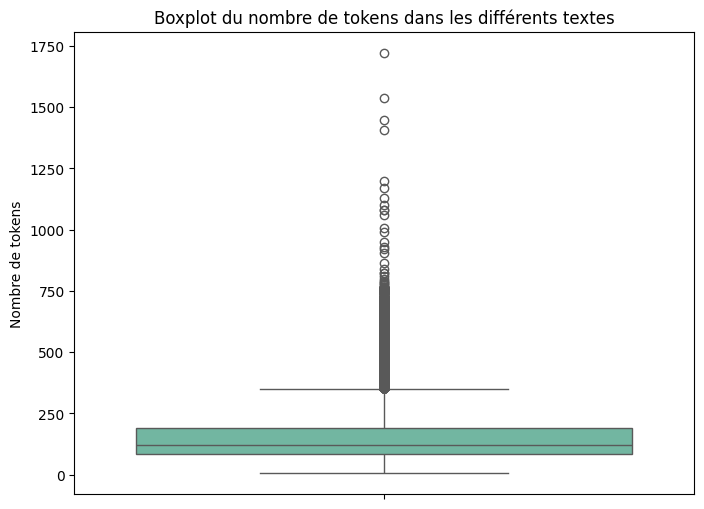

In [8]:
# Création du boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=texts_lengths, palette='Set2')

plt.title('Boxplot du nombre de tokens dans les différents textes')
plt.ylabel('Nombre de tokens')

plt.show()

In [9]:
def pad_features(texts, pad_id, seq_length=256):
    # pad_id est l'indice de l'identifiant spécial <PAD> 

    sequences = np.full((len(texts), seq_length), pad_id, dtype=int) # initialisation d'une matrice feature de longueur seq_length avec l'element <PAD>

    for i, row in enumerate(texts):
        sequences[i, :len(row)] = np.array(row)[:seq_length] # feature est completee par les elements de la sequence d'entree review

    return sequences

seq_length = 256
sequences = pad_features(texts_enc, pad_id=word2int['<PAD>'], seq_length=seq_length)

assert len(sequences) == len(texts_enc)
assert len(sequences[0]) == seq_length

sequences[:10, :3] # 3 premiers élèments des 10 premières séquences

array([[  191,  1083,   930],
       [   47,   328,    59],
       [    3,    95,   328],
       [ 2408,   136,    59],
       [70998, 10569,  1081],
       [ 2795,     4,    13],
       [    3,   197,    18],
       [   14,    31,   427],
       [47907,   980,   359],
       [   64,    10,   125]])

In [10]:
labels = data_pred.label.to_numpy() # conversion des labels en numpy

# Modèles de prédiction

## Séparation du jeu de données

In [11]:
# Choix des ratios pour la séparation des données
train_size = .8     # utilisation de 80% des données pour l'apprentissage et 20% pour le test
val_size = .5       # utilisation de 50% des données test pour la validation (Total : 80% apprentissage, 10% validation, 10% test)

# Données d'apprentissage
split_id = int(len(sequences) * train_size)
train_x, remain_x = sequences[:split_id], sequences[split_id:]
train_y, remain_y = labels[:split_id], labels[split_id:]

# Données de validation et de test
split_val_id = int(len(remain_x) * val_size)
val_x, test_x = remain_x[:split_val_id], remain_x[split_val_id:]
val_y, test_y = remain_y[:split_val_id], remain_y[split_val_id:]

# print out the shape
print('Taille des échantillons:')
print('========================')
print('Train set: {}'.format(train_x.shape))
print('Validation set: {}'.format(val_x.shape))
print('Test set: {}'.format(test_x.shape))

Taille des échantillons:
Train set: (40000, 256)
Validation set: (5000, 256)
Test set: (5000, 256)


In [12]:
# Répartition des labels dans les échantillons

print("Échantillon d'apprentissage :")
print("Nombre de critiques positives : " + str(len(train_y[train_y == 0])))
print("Nombre de critiques négatives : " + str(len(train_y[train_y == 1])))
print()

print("Échantillon de validation :")
print("Nombre de critiques positives : " + str(len(val_y[val_y == 0])))
print("Nombre de critiques négatives : " + str(len(val_y[val_y == 1])))
print()

print("Échantillon test :")
print("Nombre de critiques positives : " + str(len(test_y[test_y == 0])))
print("Nombre de critiques négatives : " + str(len(test_y[test_y == 1])))
print()


Échantillon d'apprentissage :
Nombre de critiques positives : 20007
Nombre de critiques négatives : 19993

Échantillon de validation :
Nombre de critiques positives : 2463
Nombre de critiques négatives : 2537

Échantillon test :
Nombre de critiques positives : 2530
Nombre de critiques négatives : 2470



Nos classes sont donc toujours réparties de manière équitable dans les différents échantillons.

In [13]:
batch_size = 128

# Création des tenseurs
train_set = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_set = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_set = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# Création des DataLoaders
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(valid_set, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_set, shuffle=True, batch_size=batch_size)

## Création des modèles de prédiction

L'objectif dès à présent est de réussir à obtenir un modèle capable de prédire, à partir d'une critique d'un spectateur, la classe de cette critique : "positive" ou "négative". On a ici un problème de classification binaire (le modèle doit retourner 0 pour une critique négative et 1 pour une critique positive). Ceci justfie qu'en sortie de nos modèles, on utlise une fonction d'activation de type sigmoïde (en plus de renvoyer des valeurs comprises entre 0 et 1, elle contraint les valeurs renvoyées à être proches des valeurs extrêmes).

Les données récupérées précédemment via les loaders sont au format (batch_size, seq_length) et contiennent des entiers qui représentent des indices de mots dans le vocabulaire (nos tokens). Ces indices n'ont pas de signification intrinsèque pour le modèle. On va donc utiliser dans chacun des modèles de prédiction une couche d'embedding qui transforme ces indices en représentations vectorielles continues dans un espace de dimension embedding_size. Cela permettra de capturer les relations et similitudes entre les mots. Pour chaque mot (représenté par son indice), la couche d'embedding associera un vecteur dense de taille embedding_size. Ces vecteurs seront appris pendant l'entraînement pour capturer des relations sémantiques entre les mots. Ainsi, les mots ayant des significations proches ou apparaissant dans des contextes similaires auront des vecteurs proches dans l'espace des embeddings. <br>
On aurait pu envisager le cas où les données passées en entrée au modèle étaient déja vectorisées et ainsi se passer de l'étape d'embedding dans les modèles.

### Choix des hyperparamètres

Les hyperparamètres ont initialement été fixés de manière arbitraire. On cherchera à les optimiser dans une section ultérieure, en les adaptant à chaque modèle.

In [14]:
vocab_size = len(word2int)
output_size = 1

# Liste des hyperparamètres
embedding_size = 256
hidden_size = 512
n_layers = 2
dropout=0.25
dropout_layer = 0.3
lr = 0.001
epochs = 5
grad_clip = 5 # permet d'éviter le problème d'exploding gradients

### Création des modèles

On crée d'abord un modèle de RNN "classique" en utilisant la fonction <i> nn.RNN </i> du package torch. La fonction d'activation des couches cachées du réseau peut-être au choix une ReLU ou une tanh. Ici, nous avons choisi d'utiliser la fonction d'activation tanh (une ReLU risque en effet d'être instable, d'une part car les états cachés peuvent exploser (la fonction n'étant pas bornée) et d'autre part car si une valeur négative est transmise, les neurones deviennent inactifs (il y  a donc un risque que trop de neurones deviennent inactifs)).

Par ailleurs, pour les trois modèles de RNN (classique, LSTM et GRU), des couches de dropout ont été introduites à deux niveaux :
- Au niveau des connexions entre les couches récurrentes : il empêche le surapprentissage en rendant les connexions entre ces couches moins dépendantes.
- Hors de la structure récurrente  : au niveau des couches denses pour régulariser les activations avant de passer à la phase finale de prédiction. Il permet donc d'éviter le surapprentissage des sorties globales.


Dans la même logique d'éviter le surapprentissage, dans le MLP des couches de dropout ont été introduites au niveau des différentes couches denses, et dans le CNN au niveau de la dernière couche dense (à nouveau juste avant la prédiction finale).

In [15]:
class Modele_RNN(nn.Module):
    def __init__(self, vocab_size, output_size, hidden_size=128, embedding_size=400, n_layers=2, dropout=0.2, dropout_layer = 0.3):
        super(Modele_RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.rnn = nn.RNN(embedding_size, hidden_size, n_layers, nonlinearity='tanh', dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout_layer)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.long()
        x = self.embedding(x)
        o, _ = self.rnn(x)
        o = o[:, -1, :]
        o = self.dropout(o)
        o = self.fc(o)
        o = self.sigmoid(o)
        return o


In [16]:
model_RNN = Modele_RNN(vocab_size, output_size, hidden_size, embedding_size, n_layers, dropout, dropout_layer)
print(model_RNN)

Modele_RNN(
  (embedding): Embedding(121332, 256)
  (rnn): RNN(256, 512, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [17]:
class Modele_LSTM(nn.Module):
    def __init__(self, vocab_size, output_size, hidden_size=128, embedding_size=400, n_layers=2, dropout=0.2, dropout_layer = 0.3):
        super(Modele_LSTM, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_size) # couche d'embedding pour "mapper" les entrées en vecteurs
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout_layer)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        
        x = x.long() # conversion en entiers longs
        x = self.embedding(x)
        o, _ =  self.lstm(x) # 'o' = la sortie à chaque pas de temps
        o = o[:, -1, :] # récupération de la dernière sortie temporelle
        o = self.dropout(o) # desactivation aléatoire des neurones (pour éviter le surapprentissage)
        o = self.fc(o) # output_size=1 car classification binaire
        o = self.sigmoid(o) # fonction d'activation sigmoïde pour la prédiction (renvoie une proba entre 0 et 1 d'appartenir à la classe positive)

        return o
        

In [18]:
model_LSTM = Modele_LSTM(vocab_size, output_size, hidden_size, embedding_size, n_layers, dropout, dropout_layer)
print(model_LSTM)

Modele_LSTM(
  (embedding): Embedding(121332, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [19]:
class Modele_GRU(nn.Module):
    def __init__(self, vocab_size, output_size, hidden_size=128, embedding_size=400, n_layers=2, dropout=0.2, dropout_layer = 0.3):
        super(Modele_GRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.rnn = nn.GRU(embedding_size, hidden_size, n_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout_layer)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.long()
        x = self.embedding(x)
        o, _ = self.rnn(x)
        o = o[:, -1, :]
        o = self.dropout(o)
        o = self.fc(o)
        o = self.sigmoid(o)
        return o


In [20]:
model_GRU = Modele_GRU(vocab_size, output_size, hidden_size, embedding_size, n_layers, dropout, dropout_layer)
print(model_GRU)

Modele_GRU(
  (embedding): Embedding(121332, 256)
  (rnn): GRU(256, 512, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [21]:
class Modele_MLP(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_size=256, hidden_size=512, dropout=0.25):
        super(Modele_MLP, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.fc1 = nn.Linear(embedding_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()

        self.to(device)

    def forward(self, x):
        x = x.long().to(device)
        x = self.embedding(x)
        x = x.mean(dim=1)  # Moyenne sur la séquence de mots
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.sigmoid(x)

        return x



In [22]:
model_MLP = Modele_MLP(vocab_size, output_size, embedding_size, hidden_size, dropout_layer)
print(model_MLP)

Modele_MLP(
  (embedding): Embedding(121332, 256)
  (fc1): Linear(in_features=256, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (sigmoid): Sigmoid()
)


In [23]:
class Modele_CNN(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_size=400, n_filters=100, filter_sizes=[3, 4, 5], dropout=0.5):
        super(Modele_CNN, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_size, out_channels=n_filters, kernel_size=fs) # couches de convolution avec différentes tailles de filtres (par défault 3 pour des motifs plus locaux, 5 pour des motifs plus larges)
            for fs in filter_sizes
        ])

        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_size) # couche entièrement connectée
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.long()
        x = self.embedding(x)

        x = x.transpose(1, 2)  # on intervertit les dimensions pour avoir le bon format pour la fonction Conv1D
        conv_outputs = [F.relu(conv(x)) for conv in self.convs] # appel des différentes couches de convolution auxquelles on applique des fonctions d'activation de type ReLu
        pooled_outputs = [F.max_pool1d(conv_output, conv_output.size(2)).squeeze(2) for conv_output in conv_outputs] # max_pooling pour réduire la dimension à chaque fois
        x = torch.cat(pooled_outputs, dim=1) # concaténation des pooled_outputs
        
        x = self.dropout(x) # régularisation avec un dropout
        x = self.fc(x) # couche entièrement connectée
        x = self.sigmoid(x) # classification binaire
        
        return x


In [24]:
n_filters = 100 # 50 à 300
filter_sizes=[3, 4, 5]

model_CNN = Modele_CNN(vocab_size, output_size, embedding_size, n_filters, filter_sizes, dropout_layer)
print(model_CNN)

Modele_CNN(
  (embedding): Embedding(121332, 256)
  (convs): ModuleList(
    (0): Conv1d(256, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(256, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(256, 100, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (sigmoid): Sigmoid()
)


### Entraînement des modèles

Pour tous les modèles, la fonction de perte utilisée est la BCE (Binary Cross-Entropy) car on a ici un problème de classification binaire. <br>
L'optimiseur utilisé est quant à lui Adam, qui a révélé de bonnes performances dans des cas de classifications analogues dans la littérature.

#### Modèle naïf : exemple avec un modèle de type LSTM

Dans un premier temps, on tente d'appliquer un modèle dit "naïf" de LSTM, c'est-à-dire que les paramètres utilisés ne sont pas optimisés. Cela permet simplement d'avoir un premier aperçu des performances du modèle. L'optimisation des hyperparamètres sera réalisée ultérieurement.

In [25]:
criterion = nn.BCELoss()  # Binary Cross-Entropy car classification binaire
optim = Adam(model_LSTM.parameters(), lr=lr)
print_every = 1
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epochs': epochs
}
es_limit = 5

Pour évaluer les performances du modèle :

- On observe l'évolution de la fonction de perte (loss) des données d'apprentissage et de test : l'objectif est de voir si la loss diminue pour les deux ensembles de données.
- Si la loss de la validation ne diminue pas pour 5 epochs consécutives, alors on arrête l'entraînement (early stopping).
- On calcule à chaque epoch l'accuracy (c'est-à-dire le taux de bonnes prédictions globales) : plus il est élevé, plus le modèle est performant.

In [ ]:
model_LSTM = model_LSTM.to(device)

epochloop = tqdm(range(epochs), position=0, desc='Training', leave=True)

# early stop trigger
es_trigger = 0
val_loss_min = torch.inf

for e in epochloop:

    #################
    # training mode #
    #################

    model_LSTM.train()

    train_loss = 0
    train_acc = 0

    for id, (feature, target) in enumerate(train_loader):
        
        epochloop.set_postfix_str(f'Training batch {id}/{len(train_loader)}')

        feature, target = feature.to(device), target.to(device)

        # reset de l'optimiseur
        optim.zero_grad()

        out = model_LSTM(feature)

        # accuracy
        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        train_acc += acc.item()

        # loss
        loss = criterion(out.squeeze(), target.float())
        train_loss += loss.item()
        loss.backward()

        nn.utils.clip_grad_norm_(model_LSTM.parameters(), grad_clip)

        # optimiseur mis à jour
        optim.step()

        # libère de la mémoire
        del feature, target, predicted

    history['train_loss'].append(train_loss / len(train_loader))
    history['train_acc'].append(train_acc / len(train_loader))

    ####################
    # validation model #
    ####################

    model_LSTM.eval()

    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for id, (feature, target) in enumerate(val_loader):
            
            epochloop.set_postfix_str(f'Validation batch {id}/{len(val_loader)}')
            
            feature, target = feature.to(device), target.to(device)

            out = model_LSTM(feature)

            # accuracy
            predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
            equals = predicted == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            val_acc += acc.item()

            # loss
            loss = criterion(out.squeeze(), target.float())
            val_loss += loss.item()

            # libère de la mémoire
            del feature, target, predicted

        history['val_loss'].append(val_loss / len(val_loader))
        history['val_acc'].append(val_acc / len(val_loader))

    # repasse le modèle en mode entrainement
    model_LSTM.train()

    epochloop.set_postfix_str(f'Val Loss: {val_loss / len(val_loader):.3f} | Val Acc: {val_acc / len(val_loader):.3f}')
 
    if (e+1) % print_every == 0:
        epochloop.write(f'Epoch {e+1}/{epochs} | Train Loss: {train_loss / len(train_loader):.3f} Train Acc: {train_acc / len(train_loader):.3f} | Val Loss: {val_loss / len(val_loader):.3f} Val Acc: {val_acc / len(val_loader):.3f}')
        epochloop.update()

    # sauvegarde le modèle si la perte de validation diminue
    if val_loss / len(val_loader) <= val_loss_min:
        torch.save(model_LSTM.state_dict(), './sentiment_lstm.pt')
        val_loss_min = val_loss / len(val_loader)
        es_trigger = 0
    else:
        epochloop.write(f'[WARNING] Validation loss did not improved ({val_loss_min:.3f} --> {val_loss / len(val_loader):.3f})')
        es_trigger += 1

    # early stopping si le modèle ne s'améliore pas
    if es_trigger >= es_limit:
        epochloop.write(f'Early stopped at Epoch-{e+1}')
        
        history['epochs'] = e+1
        break

Training:  20%|██        | 1/5 [00:56<03:45, 56.31s/it, Val Loss: 0.695 | Val Acc: 0.511]

Epoch 1/5 | Train Loss: 0.694 Train Acc: 0.506 | Val Loss: 0.695 Val Acc: 0.511


Training:  60%|██████    | 3/5 [01:52<01:15, 37.92s/it, Val Loss: 0.692 | Val Acc: 0.507]

Epoch 2/5 | Train Loss: 0.693 Train Acc: 0.502 | Val Loss: 0.692 Val Acc: 0.507


Training: 100%|██████████| 5/5 [02:48<00:00, 45.26s/it, Training batch 1/313]            

Epoch 3/5 | Train Loss: 0.686 Train Acc: 0.526 | Val Loss: 0.693 Val Acc: 0.514
[WARNING] Validation loss did not improved (0.692 --> 0.693)


Training: 6it [03:43, 35.83s/it, Val Loss: 0.560 | Val Acc: 0.729]                       

Epoch 4/5 | Train Loss: 0.552 Train Acc: 0.708 | Val Loss: 0.560 Val Acc: 0.729


Training: 7it [04:40, 41.52s/it, Val Loss: 0.407 | Val Acc: 0.837]

Epoch 5/5 | Train Loss: 0.350 Train Acc: 0.858 | Val Loss: 0.407 Val Acc: 0.837


Training: 100%|██████████| 5/5 [04:41<00:00, 56.32s/it, Val Loss: 0.407 | Val Acc: 0.837]


On affiche maintenant l'évolution de la loss et de l'accuracy au cours de l'entraînement.

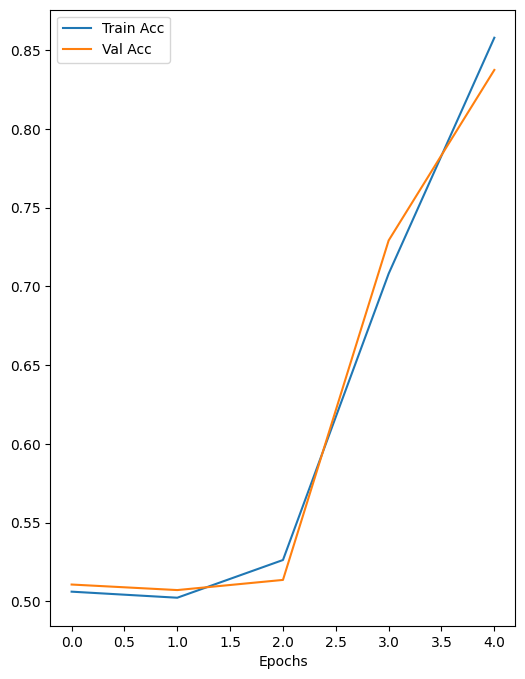

In [ ]:
# Affichage du taux de bonnes prédictions
plt.figure(figsize=(6, 8))
plt.plot(range(history['epochs']), history['train_acc'], label='Train Acc')
plt.plot(range(history['epochs']), history['val_acc'], label='Val Acc')
plt.xlabel("Epochs")
plt.legend()
plt.show()

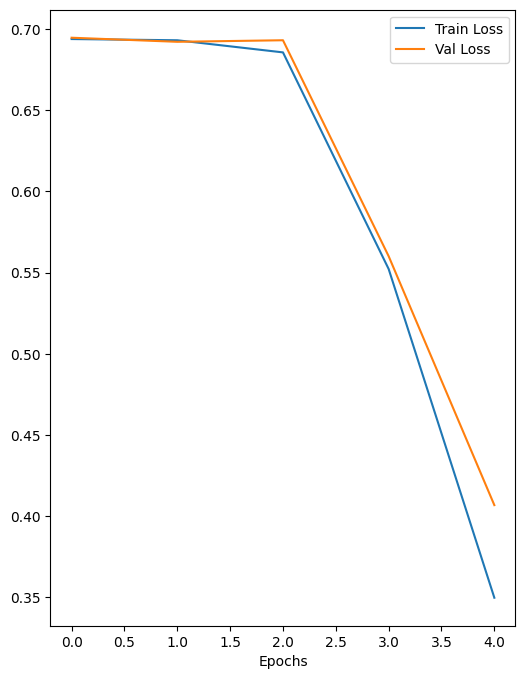

In [ ]:
# Affichage de la fonction de perte
plt.figure(figsize=(6, 8))
plt.plot(range(history['epochs']), history['train_loss'], label='Train Loss')
plt.plot(range(history['epochs']), history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.legend()
plt.show()

On constate que le modèle non optimisé est déjà très performant :

- La loss est décroissante au cours des itérations à la fois pour les données d'apprentissage et de validation (pas de surapprentissage).
- On obtient de bonnes performances globales en terme de prédictions sur les deux ensembles de données (autour de 86% de bonnes prédictions pour l'apprentissage et de 84% pour la validation).

#### Modèle optimisé LSTM

On cherche maintenant à optimiser nos hyperparamètres afin de voir si l'on peut obtenir de meilleures performances de prédiction. Pour cela, on a recours à de l'optimisation bayésienne.  Le principe est le suivant : on veut trouver les hyperparamètres qui minimisent une fonction objectif. Ici notre objectif est la minimisation de la validation loss, et pour chaque hyperparamètre que l'on veut optimiser, on donne une plage de valeurs possibles à la fonction. <br>
Contrairement à des méthodes comme la recherche aléatoire ou par grille, l'optimisation bayésienne construit un modèle probabiliste (souvent un processus gaussien) pour approximer la fonction objectif. Au fur et à mesure, elle teste différentes combinaisons de paramètres et cherche un équilibre entre 2 critères : l'exploration d'une part (c'est-à-dire la recherche de nouvelles régions intéressantes) et l'exploitation d'autre part (c'est-à-dire tester les zones jugées prometteuses).

In [41]:
def optim_LSTM(trial):
    # Hyperparamètres à tester
    embedding_size = trial.suggest_int('embedding_size', 128, 512)
    hidden_size = trial.suggest_int('hidden_size', 128, 512)
    dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
    dropout_layer = trial.suggest_uniform('dropout_layer', 0.2, 0.5)
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-3)
    batch_size = trial.suggest_int('batch_size', 64, 128)
    epochs = trial.suggest_int('epochs', 5, 15)
    n_layers = trial.suggest_int('n_layers', 2, 4)

    # Création d'un modèle avec ces hyperparamètres
    model = Modele_LSTM(vocab_size, output_size, 
                        embedding_size=embedding_size, 
                        hidden_size=hidden_size, 
                        dropout=dropout,
                        n_layers=n_layers,
                        dropout_layer=dropout_layer).to(device)
    
    # Définir l'optimiseur et la fonction de perte
    optimizer = Adam(model.parameters(), lr=lr)
    
    # DataLoader pour charger les données par batch
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
    
    # Affichage de la barre de progression pour les époques
    epochloop = tqdm(range(epochs), position=0, desc=f"Trial {trial.number} | Training", leave=True)
    
    # Entraîner le modèle pendant les 'epochs' suggérées
    for epoch in epochloop:
        model.train()
        train_loss = 0
        for feature, target in train_loader:
            feature, target = feature.to(device), target.to(device)
            optimizer.zero_grad()
            out = model(feature)
            loss = criterion(out.squeeze(), target.float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation du modèle
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for feature, target in val_loader:
                feature, target = feature.to(device), target.to(device)
                out = model(feature)
                loss = criterion(out.squeeze(), target.float())
                val_loss += loss.item()

        # Mise à jour de la barre de progression de l'époch avec la validation
        epochloop.set_postfix({'val_loss': val_loss / len(val_loader)})
    
    # Retourner la perte de validation, qu'Optuna va minimiser
    return val_loss / len(val_loader)




In [42]:
# Créer un objet study Optuna
opti_LSTM = optuna.create_study(direction='minimize')  # On minimise la perte

# Lancer l'optimisation
opti_LSTM.optimize(optim_LSTM, n_trials=15)  # Teste 15 configurations différentes

# Afficher les meilleurs hyperparamètres trouvés
print(f"Meilleurs hyperparamètres : {opti_LSTM.best_params}")
print(f"Meilleure valeur de la perte : {opti_LSTM.best_value}")


[I 2024-12-08 17:30:27,016] A new study created in memory with name: no-name-c1514544-7070-4c21-baec-a8a9e74fa1e8
/tmp/ipykernel_6238/1306528238.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipykernel_6238/1306528238.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_layer = trial.suggest_uniform('dropout_layer', 0.2, 0.5)
/tmp/ipykernel_6238/1306528238.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-3)
Trial 0 | Training: 100%

Meilleurs hyperparamètres : {'embedding_size': 357, 'hidden_size': 462, 'dropout': 0.3179092388749985, 'dropout_layer': 0.2509381610435122, 'lr': 0.0003302036064699447, 'batch_size': 86, 'epochs': 8, 'n_layers': 2}
Meilleure valeur de la perte : 0.3594136829093351


On crée maintenant un nouveau modèle de LSTM en utilisant les paramètres optimisés, c'est-à-dire ceux ayant permis d'obtenir la valeur de validation loss la plus faible.

In [43]:
# Crée un modèle final avec les meilleurs hyperparamètres
best_params_LSTM = opti_LSTM.best_params
best_model_LSTM = Modele_LSTM(vocab_size, output_size, 
                         embedding_size = best_params_LSTM['embedding_size'], 
                         hidden_size = best_params_LSTM['hidden_size'], 
                         dropout = best_params_LSTM['dropout'], 
                         n_layers = best_params_LSTM['n_layers'], 
                         dropout_layer = best_params_LSTM['dropout_layer']).to(device)

# Optimiseur avec le meilleur learning rate
optimizer_LSTM = Adam(best_model_LSTM.parameters(), lr=best_params_LSTM['lr'])
epochs_LSTM = best_params_LSTM['epochs']

print_every = 1
history_LSTM = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epochs': epochs_LSTM
}


In [44]:
best_model_LSTM = best_model_LSTM.to(device)

epochloop = tqdm(range(epochs_LSTM), position=0, desc='Training', leave=True)

# early stop trigger
es_trigger = 0
val_loss_min = torch.inf

for e in epochloop:

    #################
    # training mode #
    #################

    best_model_LSTM.train()

    train_loss = 0
    train_acc = 0

    for id, (feature, target) in enumerate(train_loader):
        epochloop.set_postfix_str(f'Training batch {id}/{len(train_loader)}')

        feature, target = feature.to(device), target.to(device)

        optimizer_LSTM.zero_grad()

        out = best_model_LSTM(feature)

        # accuracy
        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        train_acc += acc.item()

        # loss
        loss = criterion(out.squeeze(), target.float())
        train_loss += loss.item()
        loss.backward()

        nn.utils.clip_grad_norm_(best_model_LSTM.parameters(), grad_clip)

        optimizer_LSTM.step()

        # libération de la mémoire
        del feature, target, predicted

    history_LSTM['train_loss'].append(train_loss / len(train_loader))
    history_LSTM['train_acc'].append(train_acc / len(train_loader))

    ####################
    # validation model #
    ####################

    best_model_LSTM.eval() # passe le modèle en mode évaluation

    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for id, (feature, target) in enumerate(val_loader):
            
            epochloop.set_postfix_str(f'Validation batch {id}/{len(val_loader)}')
            
            feature, target = feature.to(device), target.to(device)

            out = best_model_LSTM(feature)

            # accuracy
            predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
            equals = predicted == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            val_acc += acc.item()

            # loss
            loss = criterion(out.squeeze(), target.float())
            val_loss += loss.item()

            # libération de la mémoire
            del feature, target, predicted

        history_LSTM['val_loss'].append(val_loss / len(val_loader))
        history_LSTM['val_acc'].append(val_acc / len(val_loader))

    best_model_LSTM.train()

    epochloop.set_postfix_str(f'Val Loss: {val_loss / len(val_loader):.3f} | Val Acc: {val_acc / len(val_loader):.3f}')

    if (e+1) % print_every == 0:
        epochloop.write(f'Epoch {e+1}/{epochs} | Train Loss: {train_loss / len(train_loader):.3f} Train Acc: {train_acc / len(train_loader):.3f} | Val Loss: {val_loss / len(val_loader):.3f} Val Acc: {val_acc / len(val_loader):.3f}')
        epochloop.update()

    # sauvegarde le modèle uniquement si la fonction de perte décroît
    if val_loss / len(val_loader) <= val_loss_min:
        torch.save(best_model_LSTM.state_dict(), './sentiment_lstm.pt')
        val_loss_min = val_loss / len(val_loader)
        es_trigger = 0
    else:
        epochloop.write(f'[WARNING] Validation loss did not improved ({val_loss_min:.3f} --> {val_loss / len(val_loader):.3f})')
        es_trigger += 1

    # early stopping
    if es_trigger >= es_limit:
        epochloop.write(f'Early stopped at Epoch-{e+1}')
        history_LSTM['epochs'] = e+1
        break

Training:  12%|█▎        | 1/8 [00:51<06:02, 51.74s/it, Val Loss: 0.693 | Val Acc: 0.498]

Epoch 1/5 | Train Loss: 0.693 Train Acc: 0.506 | Val Loss: 0.693 Val Acc: 0.498


Training:  38%|███▊      | 3/8 [01:46<03:01, 36.29s/it, Val Loss: 0.690 | Val Acc: 0.522]

Epoch 2/5 | Train Loss: 0.685 Train Acc: 0.534 | Val Loss: 0.690 Val Acc: 0.522


Training:  50%|█████     | 4/8 [02:42<02:56, 44.09s/it, Val Loss: 0.655 | Val Acc: 0.648]

Epoch 3/5 | Train Loss: 0.668 Train Acc: 0.555 | Val Loss: 0.655 Val Acc: 0.648


Training:  75%|███████▌  | 6/8 [03:38<01:14, 37.45s/it, Val Loss: 0.643 | Val Acc: 0.648]

Epoch 4/5 | Train Loss: 0.648 Train Acc: 0.592 | Val Loss: 0.643 Val Acc: 0.648


Training:  88%|████████▊ | 7/8 [04:34<00:43, 43.58s/it, Val Loss: 0.540 | Val Acc: 0.748]

Epoch 5/5 | Train Loss: 0.528 Train Acc: 0.756 | Val Loss: 0.540 Val Acc: 0.748


Training: 100%|██████████| 8/8 [05:31<00:00, 47.67s/it, Val Loss: 0.452 | Val Acc: 0.807]

Epoch 6/5 | Train Loss: 0.432 Train Acc: 0.814 | Val Loss: 0.452 Val Acc: 0.807


Training: 10it [06:27, 39.82s/it, Val Loss: 0.434 | Val Acc: 0.826]                      

Epoch 7/5 | Train Loss: 0.355 Train Acc: 0.854 | Val Loss: 0.434 Val Acc: 0.826


Training: 11it [07:23, 44.93s/it, Val Loss: 0.376 | Val Acc: 0.845]

Epoch 8/5 | Train Loss: 0.296 Train Acc: 0.882 | Val Loss: 0.376 Val Acc: 0.845


Training: 100%|██████████| 8/8 [07:25<00:00, 55.72s/it, Val Loss: 0.376 | Val Acc: 0.845]


In [45]:
# Sauvegarder à la fois les poids du modèle et les paramètres optimaux
checkpoint = {
    'model_state_dict': best_model_LSTM.state_dict(),
    'best_params': best_params_LSTM
}

torch.save(checkpoint, 'best_model_checkpoint.pth')

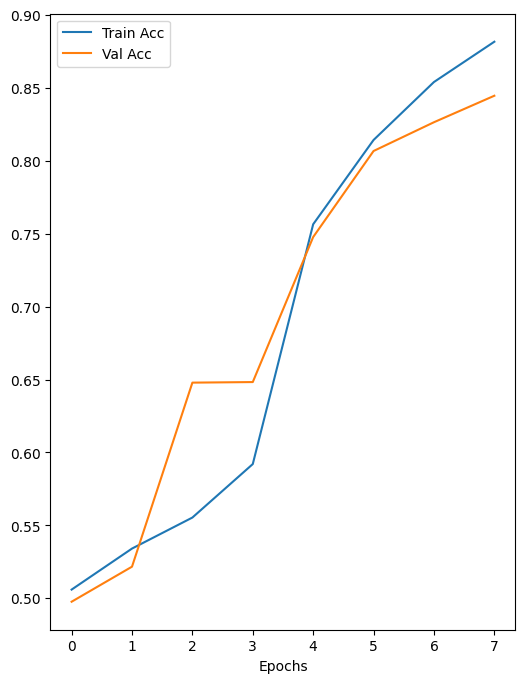

In [46]:
#  Affichage du taux de bonnes prédictions
plt.figure(figsize=(6, 8))
plt.plot(range(history_LSTM['epochs']), history_LSTM['train_acc'], label='Train Acc')
plt.plot(range(history_LSTM['epochs']), history_LSTM['val_acc'], label='Val Acc')
plt.xlabel("Epochs")
plt.legend()
plt.show()

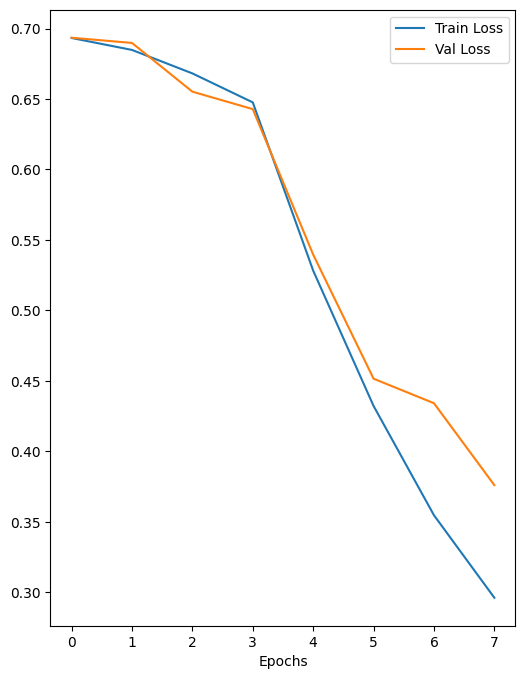

In [47]:
# Affichage de la fonction de perte
plt.figure(figsize=(6, 8))
plt.plot(range(history_LSTM['epochs']), history_LSTM['train_loss'], label='Train Loss')
plt.plot(range(history_LSTM['epochs']), history_LSTM['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.legend()
plt.show()

On constate que les valeurs de loss de l'apprentissage et de la validation ont légèrement diminué (passant respectivement de 0.35 à 0.30 et de 0.41 à 0.38). <br>
De même, les valeurs d'accuracy ont légèrement augmenté passant de 86% à 88% pour l'apprentissage et de 84% à 85% pour la validation.

L'optimisation des parmètres a donc bien permis d'améliorer les performances du modèle, mais en soi les paramètres initiaux étaient déjà très "bons" et l'optimisation est coûteuse en temps de calcul.

#### GRU

In [48]:
def optim_GRU(trial):
    # Hyperparamètres à tester
    embedding_size = trial.suggest_int('embedding_size', 128, 512)
    hidden_size = trial.suggest_int('hidden_size', 128, 512)
    dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
    dropout_layer = trial.suggest_uniform('dropout_layer', 0.2, 0.5)
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-3)
    batch_size = trial.suggest_int('batch_size', 64, 128)
    epochs = trial.suggest_int('epochs', 5, 15)
    n_layers = trial.suggest_int('n_layers', 2, 4)
    
    # Création d'un modèle avec ces hyperparamètres
    model = Modele_GRU(vocab_size, output_size, 
                        embedding_size=embedding_size, 
                        hidden_size=hidden_size, 
                        dropout=dropout,
                        n_layers=n_layers,
                        dropout_layer=dropout_layer).to(device)
    
    optimizer = Adam(model.parameters(), lr=lr)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
    
    epochloop = tqdm(range(epochs), position=0, desc=f"Trial {trial.number} | Training", leave=True)
    
    # Entraînement du modèle pendant les 'epochs' suggérées
    for epoch in epochloop:
        model.train()
        train_loss = 0
        for feature, target in train_loader:
            feature, target = feature.to(device), target.to(device)
            optimizer.zero_grad()
            out = model(feature)
            loss = criterion(out.squeeze(), target.float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for feature, target in val_loader:
                feature, target = feature.to(device), target.to(device)
                out = model(feature)
                loss = criterion(out.squeeze(), target.float())
                val_loss += loss.item()

        epochloop.set_postfix({'val_loss': val_loss / len(val_loader)})
    
    return val_loss / len(val_loader)




In [49]:
opti_GRU = optuna.create_study(direction='minimize')

opti_GRU.optimize(optim_GRU, n_trials=15)

# Afficher les meilleurs hyperparamètres trouvés
print(f"Meilleurs hyperparamètres : {opti_GRU.best_params}")

print(f"Meilleure valeur de la perte : {opti_GRU.best_value}")


[I 2024-12-08 20:49:23,114] A new study created in memory with name: no-name-e3c422ec-9477-4263-8e23-7e7172bef5d4
/tmp/ipykernel_6238/334537823.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipykernel_6238/334537823.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_layer = trial.suggest_uniform('dropout_layer', 0.2, 0.5)
/tmp/ipykernel_6238/334537823.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-3)
Trial 0 | Training: 100%|██

Meilleurs hyperparamètres : {'embedding_size': 408, 'hidden_size': 220, 'dropout': 0.2872154096557581, 'dropout_layer': 0.36787840651591125, 'lr': 0.00011631508528445753, 'batch_size': 105, 'epochs': 8, 'n_layers': 2}
Meilleure valeur de la perte : 0.33356615869949263


In [50]:
# Crée un modèle final avec les meilleurs hyperparamètres
best_params_GRU = opti_GRU.best_params
best_model_GRU = Modele_GRU(vocab_size, output_size, 
                         embedding_size = best_params_GRU['embedding_size'], 
                         hidden_size = best_params_GRU['hidden_size'], 
                         dropout = best_params_GRU['dropout'], 
                         n_layers = best_params_GRU['n_layers'], 
                         dropout_layer = best_params_GRU['dropout_layer']).to(device)

optimizer_GRU = Adam(best_model_GRU.parameters(), lr=best_params_GRU['lr'])
epochs_GRU = best_params_GRU['epochs']

print_every = 1
history_GRU = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epochs': epochs_GRU
}


In [51]:
best_model_GRU = best_model_GRU.to(device)

epochloop = tqdm(range(epochs_GRU), position=0, desc='Training', leave=True)

# early stop trigger
es_trigger = 0
val_loss_min = torch.inf

for e in epochloop:

    #################
    # training mode #
    #################

    best_model_GRU.train()

    train_loss = 0
    train_acc = 0

    for id, (feature, target) in enumerate(train_loader):
        
        epochloop.set_postfix_str(f'Training batch {id}/{len(train_loader)}')

        feature, target = feature.to(device), target.to(device)

        optimizer_GRU.zero_grad()

        out = best_model_GRU(feature)

        # accuracy
        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        train_acc += acc.item()

        # loss
        loss = criterion(out.squeeze(), target.float())
        train_loss += loss.item()
        loss.backward()

        nn.utils.clip_grad_norm_(best_model_GRU.parameters(), grad_clip)

        optimizer_GRU.step()

        del feature, target, predicted

    history_GRU['train_loss'].append(train_loss / len(train_loader))
    history_GRU['train_acc'].append(train_acc / len(train_loader))

    ####################
    # validation model #
    ####################

    best_model_GRU.eval()

    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for id, (feature, target) in enumerate(val_loader):

            epochloop.set_postfix_str(f'Validation batch {id}/{len(val_loader)}')
            
            feature, target = feature.to(device), target.to(device)

            out = best_model_GRU(feature)

            # accuracy
            predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
            equals = predicted == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            val_acc += acc.item()

            # loss
            loss = criterion(out.squeeze(), target.float())
            val_loss += loss.item()

            del feature, target, predicted

        history_GRU['val_loss'].append(val_loss / len(val_loader))
        history_GRU['val_acc'].append(val_acc / len(val_loader))

    best_model_GRU.train()

    epochloop.set_postfix_str(f'Val Loss: {val_loss / len(val_loader):.3f} | Val Acc: {val_acc / len(val_loader):.3f}')

    if (e+1) % print_every == 0:
        epochloop.write(f'Epoch {e+1}/{epochs} | Train Loss: {train_loss / len(train_loader):.3f} Train Acc: {train_acc / len(train_loader):.3f} | Val Loss: {val_loss / len(val_loader):.3f} Val Acc: {val_acc / len(val_loader):.3f}')
        epochloop.update()

    if val_loss / len(val_loader) <= val_loss_min:
        torch.save(best_model_GRU.state_dict(), './sentiment_gru.pt')
        val_loss_min = val_loss / len(val_loader)
        es_trigger = 0
    else:
        epochloop.write(f'[WARNING] Validation loss did not improved ({val_loss_min:.3f} --> {val_loss / len(val_loader):.3f})')
        es_trigger += 1

    # early stopping
    if es_trigger >= es_limit:
        epochloop.write(f'Early stopped at Epoch-{e+1}')
        history_GRU['epochs'] = e+1
        break

Training:  12%|█▎        | 1/8 [00:22<02:35, 22.17s/it, Val Loss: 0.693 | Val Acc: 0.506]

Epoch 1/5 | Train Loss: 0.696 Train Acc: 0.507 | Val Loss: 0.693 Val Acc: 0.506


Training:  38%|███▊      | 3/8 [00:46<01:19, 15.82s/it, Training batch 2/313]            

Epoch 2/5 | Train Loss: 0.695 Train Acc: 0.506 | Val Loss: 0.693 Val Acc: 0.511
[WARNING] Validation loss did not improved (0.693 --> 0.693)


Training:  50%|█████     | 4/8 [01:09<01:14, 18.59s/it, Val Loss: 0.691 | Val Acc: 0.534]

Epoch 3/5 | Train Loss: 0.693 Train Acc: 0.515 | Val Loss: 0.691 Val Acc: 0.534


Training:  75%|███████▌  | 6/8 [01:34<00:32, 16.19s/it, Val Loss: 0.599 | Val Acc: 0.672]

Epoch 4/5 | Train Loss: 0.667 Train Acc: 0.587 | Val Loss: 0.599 Val Acc: 0.672


Training:  88%|████████▊ | 7/8 [01:59<00:19, 19.14s/it, Val Loss: 0.434 | Val Acc: 0.804]

Epoch 5/5 | Train Loss: 0.471 Train Acc: 0.790 | Val Loss: 0.434 Val Acc: 0.804


Training: 100%|██████████| 8/8 [02:24<00:00, 21.03s/it, Val Loss: 0.389 | Val Acc: 0.839]

Epoch 6/5 | Train Loss: 0.349 Train Acc: 0.861 | Val Loss: 0.389 Val Acc: 0.839


Training: 10it [02:50, 17.54s/it, Val Loss: 0.358 | Val Acc: 0.851]                      

Epoch 7/5 | Train Loss: 0.285 Train Acc: 0.890 | Val Loss: 0.358 Val Acc: 0.851


Training: 100%|██████████| 8/8 [03:15<00:00, 24.40s/it, Val Loss: 0.371 | Val Acc: 0.851]

Epoch 8/5 | Train Loss: 0.238 Train Acc: 0.913 | Val Loss: 0.371 Val Acc: 0.851
[WARNING] Validation loss did not improved (0.358 --> 0.371)


In [52]:
# Sauvegarde à la fois les poids du modèle et les paramètres optimaux
checkpoint = {
    'model_state_dict': best_model_GRU.state_dict(),
    'best_params': best_params_GRU
}

torch.save(checkpoint, 'best_model_checkpoint_gru.pth')

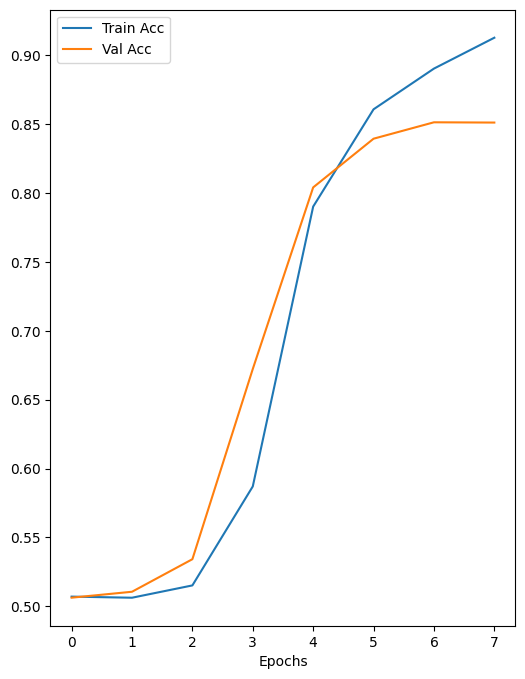

In [53]:
#  Affichage du taux de bonnes prédictions
plt.figure(figsize=(6, 8))
plt.plot(range(history_GRU['epochs']), history_GRU['train_acc'], label='Train Acc')
plt.plot(range(history_GRU['epochs']), history_GRU['val_acc'], label='Val Acc')
plt.xlabel("Epochs")
plt.legend()
plt.show()

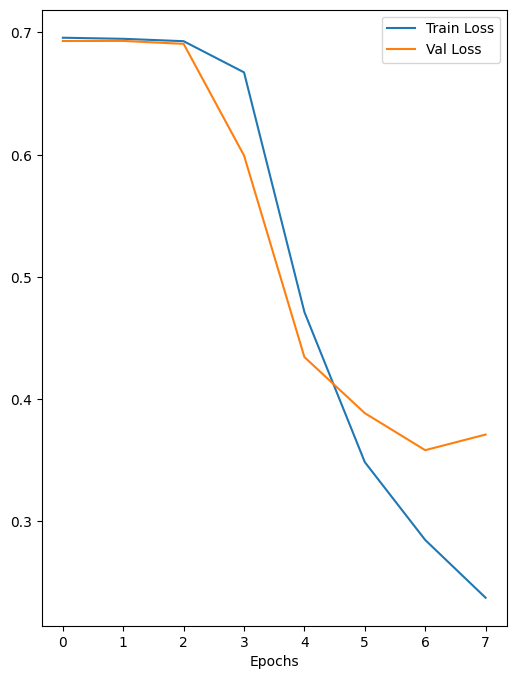

In [54]:
# Affichage de la fonction de perte
plt.figure(figsize=(6, 8))
plt.plot(range(history_GRU['epochs']), history_GRU['train_loss'], label='Train Loss')
plt.plot(range(history_GRU['epochs']), history_GRU['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.legend()
plt.show()

On constate que les résultats obtenus pour un modèle GRU sont aussi bons que ceux obtenus pour le modèle LSTM (les résultats finaux sont légèrement meilleurs pour l'apprentissage et similaires pour la validation).

Par ailleurs, pour la validation, on remarque qu'entre les epochs 6 et 7 l'accuracy stagne et la loss remonte même légèrement, ce qui manifeste un léger surapprentissage.

#### RNN "classique"

In [25]:
def optim_RNN(trial):
    # Définir les hyperparamètres à tester
    embedding_size = trial.suggest_int('embedding_size', 128, 512)
    hidden_size = trial.suggest_int('hidden_size', 128, 512)
    dropout = trial.suggest_uniform('dropout', 0.1, 0.4)
    dropout_layer = trial.suggest_uniform('dropout_layer', 0.1, 0.4)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
    batch_size = trial.suggest_int('batch_size', 64, 128)
    epochs = trial.suggest_int('epochs', 5, 15)
    n_layers = trial.suggest_int('n_layers', 2, 4)
    
    # Créer un modèle avec ces hyperparamètres
    model = Modele_RNN(vocab_size, output_size, 
                        embedding_size=embedding_size, 
                        hidden_size=hidden_size, 
                        dropout=dropout,
                        n_layers=n_layers,
                        dropout_layer=dropout_layer).to(device)
    
    # Définir l'optimiseur et la fonction de perte
    optimizer = Adam(model.parameters(), lr=lr)
    
    # DataLoader pour charger les données par batch
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
    
    # Affichage de la barre de progression pour les époques
    epochloop = tqdm(range(epochs), position=0, desc=f"Trial {trial.number} | Training", leave=True)
    
    # Entraîner le modèle pendant les 'epochs' suggérées
    for epoch in epochloop:
        model.train()
        train_loss = 0
        for feature, target in train_loader:
            feature, target = feature.to(device), target.to(device)
            optimizer.zero_grad()
            out = model(feature)
            loss = criterion(out.squeeze(), target.float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation du modèle
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for feature, target in val_loader:
                feature, target = feature.to(device), target.to(device)
                out = model(feature)
                loss = criterion(out.squeeze(), target.float())
                val_loss += loss.item()

        # Mise à jour de la barre de progression de l'époch avec la validation
        epochloop.set_postfix({'val_loss': val_loss / len(val_loader)})
    
    # Retourner la perte de validation, qu'Optuna va minimiser
    return val_loss / len(val_loader)




In [26]:
# Créer un objet study Optuna
opti_RNN = optuna.create_study(direction='minimize')

# Lancer l'optimisation
opti_RNN.optimize(optim_RNN, n_trials=25)

# Afficher les meilleurs hyperparamètres trouvés
print(f"Meilleurs hyperparamètres : {opti_RNN.best_params}")

print(f"Meilleure valeur de la perte : {opti_RNN.best_value}")


[I 2024-12-13 14:02:05,688] A new study created in memory with name: no-name-faf061e1-d65f-40b9-a0ed-054589c1d4e1
/tmp/ipykernel_9699/3608846031.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.4)
/tmp/ipykernel_9699/3608846031.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_layer = trial.suggest_uniform('dropout_layer', 0.1, 0.4)
/tmp/ipykernel_9699/3608846031.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
Trial 0 | Training: 100%

Meilleurs hyperparamètres : {'embedding_size': 352, 'hidden_size': 180, 'dropout': 0.12507398380441176, 'dropout_layer': 0.29894155539120426, 'lr': 1.3186593588981203e-05, 'batch_size': 103, 'epochs': 6, 'n_layers': 4}
Meilleure valeur de la perte : 0.6924573681792434


In [27]:
# Crée un modèle final avec les meilleurs hyperparamètres
best_params_RNN = opti_RNN.best_params
best_model_RNN = Modele_RNN(vocab_size, output_size, 
                         embedding_size = best_params_RNN['embedding_size'], 
                         hidden_size = best_params_RNN['hidden_size'], 
                         dropout = best_params_RNN['dropout'], 
                         n_layers = best_params_RNN['n_layers'], 
                         dropout_layer = best_params_RNN['dropout_layer']).to(device)

# Optimiseur avec le meilleur learning rate
optimizer_RNN = Adam(best_model_RNN.parameters(), lr=best_params_RNN['lr'])
epochs_RNN = best_params_RNN['epochs']

print_every = 1
history_RNN = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epochs': epochs_RNN
}


In [28]:
best_model_RNN = best_model_RNN.to(device)

epochloop = tqdm(range(epochs_RNN), position=0, desc='Training', leave=True)

# early stop trigger
es_trigger = 0
val_loss_min = torch.inf

for e in epochloop:

    #################
    # training mode #
    #################

    best_model_RNN.train()

    train_loss = 0
    train_acc = 0

    for id, (feature, target) in enumerate(train_loader):
        # add epoch meta info
        epochloop.set_postfix_str(f'Training batch {id}/{len(train_loader)}')

        # move to device
        feature, target = feature.to(device), target.to(device)

        # reset optimizer
        optimizer_RNN.zero_grad()

        # forward pass
        out = best_model_RNN(feature)

        # acc
        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        train_acc += acc.item()

        # loss
        loss = criterion(out.squeeze(), target.float())
        train_loss += loss.item()
        loss.backward()

        # clip grad
        nn.utils.clip_grad_norm_(best_model_RNN.parameters(), grad_clip)

        # update optimizer
        optimizer_RNN.step()

        # free some memory
        del feature, target, predicted

    history_RNN['train_loss'].append(train_loss / len(train_loader))
    history_RNN['train_acc'].append(train_acc / len(train_loader))

    ####################
    # validation model #
    ####################

    best_model_RNN.eval()

    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for id, (feature, target) in enumerate(val_loader):
            # add epoch meta info
            epochloop.set_postfix_str(f'Validation batch {id}/{len(val_loader)}')
            
            # move to device
            feature, target = feature.to(device), target.to(device)

            # forward pass
            out = best_model_RNN(feature)

            # acc
            predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
            equals = predicted == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            val_acc += acc.item()

            # loss
            loss = criterion(out.squeeze(), target.float())
            val_loss += loss.item()

            # free some memory
            del feature, target, predicted

        history_RNN['val_loss'].append(val_loss / len(val_loader))
        history_RNN['val_acc'].append(val_acc / len(val_loader))

    # reset model model
    best_model_RNN.train()

    # add epoch meta info
    epochloop.set_postfix_str(f'Val Loss: {val_loss / len(val_loader):.3f} | Val Acc: {val_acc / len(val_loader):.3f}')

    # print epoch 
    if (e+1) % print_every == 0:
        epochloop.write(f'Epoch {e+1}/{epochs_RNN} | Train Loss: {train_loss / len(train_loader):.3f} Train Acc: {train_acc / len(train_loader):.3f} | Val Loss: {val_loss / len(val_loader):.3f} Val Acc: {val_acc / len(val_loader):.3f}')
        epochloop.update()

    # save model if validation loss decrease
    if val_loss / len(val_loader) <= val_loss_min:
        torch.save(best_model_RNN.state_dict(), './sentiment_rnn.pt')
        val_loss_min = val_loss / len(val_loader)
        es_trigger = 0
    else:
        epochloop.write(f'[WARNING] Validation loss did not improved ({val_loss_min:.3f} --> {val_loss / len(val_loader):.3f})')
        es_trigger += 1

    # force early stop
    if es_trigger >= es_limit:
        epochloop.write(f'Early stopped at Epoch-{e+1}')
        # update epochs history_RNN
        history_RNN['epochs'] = e+1
        break

Training:   0%|          | 0/6 [00:00<?, ?it/s, Training batch 0/313]

Training:  17%|█▋        | 1/6 [00:16<01:21, 16.36s/it, Val Loss: 0.693 | Val Acc: 0.502]

Epoch 1/6 | Train Loss: 0.694 Train Acc: 0.499 | Val Loss: 0.693 Val Acc: 0.502


Training:  50%|█████     | 3/6 [00:45<00:43, 14.67s/it, Val Loss: 0.693 | Val Acc: 0.514]

Epoch 2/6 | Train Loss: 0.694 Train Acc: 0.504 | Val Loss: 0.693 Val Acc: 0.514


Training:  67%|██████▋   | 4/6 [01:13<00:40, 20.16s/it, Val Loss: 0.693 | Val Acc: 0.503]

Epoch 3/6 | Train Loss: 0.693 Train Acc: 0.506 | Val Loss: 0.693 Val Acc: 0.503


Training: 100%|██████████| 6/6 [01:42<00:00, 16.67s/it, Val Loss: 0.692 | Val Acc: 0.509]

Epoch 4/6 | Train Loss: 0.694 Train Acc: 0.504 | Val Loss: 0.692 Val Acc: 0.509


Training: 7it [02:10, 20.56s/it, Training batch 4/313]                                   

Epoch 5/6 | Train Loss: 0.693 Train Acc: 0.508 | Val Loss: 0.693 Val Acc: 0.507
[WARNING] Validation loss did not improved (0.692 --> 0.693)


Training: 100%|██████████| 6/6 [02:24<00:00, 24.05s/it, Val Loss: 0.693 | Val Acc: 0.495]

Epoch 6/6 | Train Loss: 0.693 Train Acc: 0.509 | Val Loss: 0.693 Val Acc: 0.495
[WARNING] Validation loss did not improved (0.692 --> 0.693)


In [31]:
# Sauvegarder à la fois les poids du modèle et les paramètres optimaux
checkpoint = {
    'model_state_dict': best_model_RNN.state_dict(),
    'best_params': best_params_RNN
}

torch.save(checkpoint, 'best_model_checkpoint_rnn.pth')

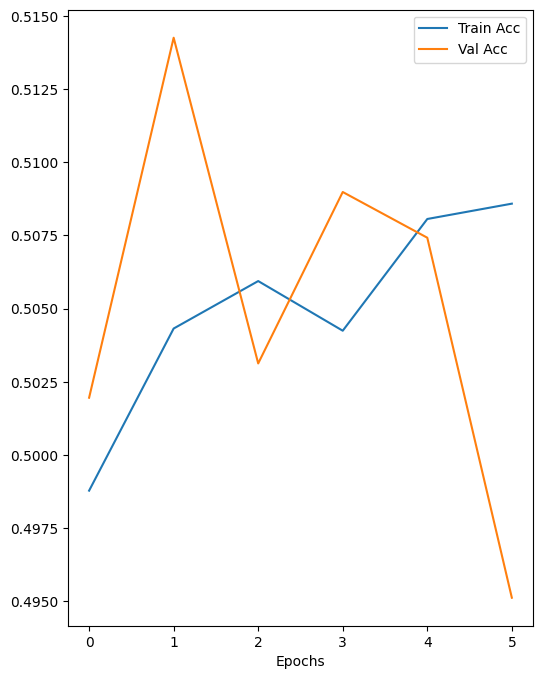

In [29]:
#  Affichage du taux de bonnes prédictions
plt.figure(figsize=(6, 8))
plt.plot(range(history_RNN['epochs']), history_RNN['train_acc'], label='Train Acc')
plt.plot(range(history_RNN['epochs']), history_RNN['val_acc'], label='Val Acc')
plt.xlabel("Epochs")
plt.legend()
plt.show()

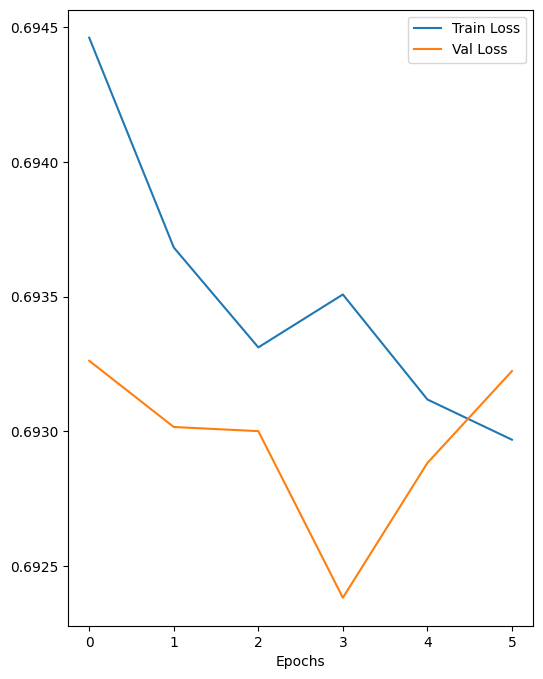

In [30]:
# Affichage de la fonction de perte
plt.figure(figsize=(6, 8))
plt.plot(range(history_RNN['epochs']), history_RNN['train_loss'], label='Train Loss')
plt.plot(range(history_RNN['epochs']), history_RNN['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.legend()
plt.show()

Pour le modèle de RNN standard, on obtient une loss et une accuracy quasi constantes à la fois pour l'apprentissage et pour la validation. L'accuracy stagne autour des 50% ce qui semble indiquer que le modèle prédit la classe aléatoirement (plus tard l'étude du jeu de données test permettra de montrer qu'en fait le modèle prédit quasi systématiquement par la classe 0, c'est-à-dire par une critique négative). Il n'y a en fait aucun apprentissage qui est effectué.

Pourtant différentes méthodes ont été envisagées pour tenter de remédier au problème :

- Diminuer la plage du Dropout dans l'optimisation Bayésienne (afin de réduire le risque d'éliminer des connexions importantes)
- Ajouter une couche de Layer Normalization dans le modèle pour essayer de le stabiliser (peut réduire la variance des activations entre les couches, ce qui favorise une convergence plus stable et rapide)
- Sans passer par de l'optimisation Bayésienne, essayer différents modèles pour lesquels : on supprimait totalement le dropout et/ou on augmentait très largement le nombre d'epochs (jusqu'à 300) et/ou on utilisait un learning rate beaucoup plus faible (convergence progressive pouvant aider à éviter d'osciller autour des minimums locaux) ou au contraire beaucoup plus élevé (une augmentation peut encourager le modèle à explorer des régions différentes)
- Changer la fonction d'activation du RNN (ReLU plutôt que tanh mais comme prévu au contraire les résultats sont encore moins performants)

Le fait que le modèle de RNN est moins performant que les modèles précédents (LSTM et GRU) peut s'expliquer par le fait que les RNN simples ont des limitations structurelles telles que la disparition des gradients ou au contraire leur explosion, qui les rend inadaptés pour capturer des dépendances à long terme dans des séquences. À l'inverse, les LSTM et GRU intègrent des mécanismes spécifiques (cellules de mémoire et portes) pour mieux gérer les dépendances temporelles et éviter ces limitations.

#### MLP

In [48]:
def optim_MLP(trial):
    # Hyperparamètres à tester
    embedding_size = trial.suggest_int('embedding_size', 128, 512)
    hidden_size = trial.suggest_int('hidden_size', 128, 512)
    dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-3)
    batch_size = trial.suggest_int('batch_size', 64, 128)
    epochs = trial.suggest_int('epochs', 5, 15)

    model = Modele_MLP(vocab_size, output_size, embedding_size=embedding_size, hidden_size=hidden_size, dropout=dropout).to(device)

    optimizer = Adam(model.parameters(), lr=lr)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for feature, target in train_loader:
            feature, target = feature.to(device), target.to(device)
            optimizer.zero_grad()
            out = model(feature)
            loss = criterion(out.squeeze(), target.float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for feature, target in val_loader:
                feature, target = feature.to(device), target.to(device)
                out = model(feature)
                loss = criterion(out.squeeze(), target.float())
                val_loss += loss.item()

    return val_loss / len(val_loader)

In [49]:
opti_MLP = optuna.create_study(direction='minimize')  # On minimise la perte

opti_MLP.optimize(optim_MLP, n_trials=15)  # Teste 5 configurations différentes

# Afficher les meilleurs hyperparamètres trouvés
print(f"Meilleurs hyperparamètres : {opti_MLP.best_params}")

print(f"Meilleure valeur de la perte : {opti_MLP.best_value}")

[I 2024-12-11 15:09:32,604] A new study created in memory with name: no-name-f048bcdf-894c-45be-b3b5-439c9bded6fa
/tmp/ipykernel_58578/2888867048.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipykernel_58578/2888867048.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-3)
[I 2024-12-11 15:10:16,035] Trial 0 finished with value: 0.32196434736251833 and parameters: {'embedding_size': 207, 'hidden_size': 215, 'dropout': 0.2847805183059675, 'lr': 0.00010121633577043845, 'batch_size': 112, 'epochs': 13}. Best is trial 0 with value: 0.32196434736251833.
[I 2024-12-11 15:10:53,466] Tria

Meilleurs hyperparamètres : {'embedding_size': 512, 'hidden_size': 136, 'dropout': 0.42482626304556975, 'lr': 0.000492881385766305, 'batch_size': 124, 'epochs': 6}
Meilleure valeur de la perte : 0.27739303250138353


In [51]:
# Crée un modèle final avec les meilleurs hyperparamètres
best_params_MLP = opti_MLP.best_params
best_model_MLP = Modele_MLP(vocab_size, output_size, 
                         embedding_size = best_params_MLP['embedding_size'], 
                         hidden_size = best_params_MLP['hidden_size'], 
                         dropout = best_params_MLP['dropout']).to(device)

optimizer_MLP = Adam(best_model_MLP.parameters(), lr=best_params_MLP['lr'])
epochs_MLP = best_params_MLP['epochs']

print_every = 1
history_MLP = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epochs': epochs_MLP
}

In [52]:
best_model_MLP = best_model_MLP.to(device)

epochloop = tqdm(range(epochs_MLP), position=0, desc='Training', leave=True)

# early stop trigger
es_trigger = 0
val_loss_min = torch.inf

for e in epochloop:

    #################
    # training mode #
    #################

    best_model_MLP.train()

    train_loss = 0
    train_acc = 0

    for id, (feature, target) in enumerate(train_loader):
        epochloop.set_postfix_str(f'Training batch {id}/{len(train_loader)}')

        feature, target = feature.to(device), target.to(device)

        optimizer_MLP.zero_grad()

        out = best_model_MLP(feature)

        # accuracy
        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        train_acc += acc.item()

        # loss
        loss = criterion(out.squeeze(), target.float())
        train_loss += loss.item()
        loss.backward()

        nn.utils.clip_grad_norm_(best_model_MLP.parameters(), grad_clip)

        optimizer_MLP.step()

        del feature, target, predicted

    history_MLP['train_loss'].append(train_loss / len(train_loader))
    history_MLP['train_acc'].append(train_acc / len(train_loader))

    ####################
    # validation model #
    ####################

    best_model_MLP.eval()

    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for id, (feature, target) in enumerate(val_loader):
            epochloop.set_postfix_str(f'Validation batch {id}/{len(val_loader)}')
            
            feature, target = feature.to(device), target.to(device)

            out = best_model_MLP(feature)

            # accuracy
            predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
            equals = predicted == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            val_acc += acc.item()

            # loss
            loss = criterion(out.squeeze(), target.float())
            val_loss += loss.item()

            del feature, target, predicted

        history_MLP['val_loss'].append(val_loss / len(val_loader))
        history_MLP['val_acc'].append(val_acc / len(val_loader))

    best_model_MLP.train()

    epochloop.set_postfix_str(f'Val Loss: {val_loss / len(val_loader):.3f} | Val Acc: {val_acc / len(val_loader):.3f}')

    if (e+1) % print_every == 0:
        epochloop.write(f'Epoch {e+1}/{epochs} | Train Loss: {train_loss / len(train_loader):.3f} Train Acc: {train_acc / len(train_loader):.3f} | Val Loss: {val_loss / len(val_loader):.3f} Val Acc: {val_acc / len(val_loader):.3f}')
        epochloop.update()

    if val_loss / len(val_loader) <= val_loss_min:
        torch.save(best_model_MLP.state_dict(), './sentiment_mlp.pt')
        val_loss_min = val_loss / len(val_loader)
        es_trigger = 0
    else:
        epochloop.write(f'[WARNING] Validation loss did not improved ({val_loss_min:.3f} --> {val_loss / len(val_loader):.3f})')
        es_trigger += 1

    # early stopping
    if es_trigger >= es_limit:
        epochloop.write(f'Early stopped at Epoch-{e+1}')
        history_MLP['epochs'] = e+1
        break

Training:  17%|█▋        | 1/6 [00:07<00:37,  7.58s/it, Val Loss: 0.611 | Val Acc: 0.630]

Epoch 1/5 | Train Loss: 0.672 Train Acc: 0.565 | Val Loss: 0.611 Val Acc: 0.630


Training:  50%|█████     | 3/6 [00:17<00:17,  5.91s/it, Val Loss: 0.339 | Val Acc: 0.860]

Epoch 2/5 | Train Loss: 0.450 Train Acc: 0.791 | Val Loss: 0.339 Val Acc: 0.860


Training:  67%|██████▋   | 4/6 [00:27<00:15,  7.66s/it, Val Loss: 0.302 | Val Acc: 0.873]

Epoch 3/5 | Train Loss: 0.318 Train Acc: 0.868 | Val Loss: 0.302 Val Acc: 0.873


Training: 100%|██████████| 6/6 [00:38<00:00,  6.40s/it, Val Loss: 0.301 | Val Acc: 0.875]

Epoch 4/5 | Train Loss: 0.265 Train Acc: 0.893 | Val Loss: 0.301 Val Acc: 0.875


Training: 7it [00:48,  7.60s/it, Val Loss: 0.282 | Val Acc: 0.886]                       

Epoch 5/5 | Train Loss: 0.222 Train Acc: 0.915 | Val Loss: 0.282 Val Acc: 0.886


Training: 100%|██████████| 6/6 [00:58<00:00,  9.70s/it, Val Loss: 0.282 | Val Acc: 0.887]

Epoch 6/5 | Train Loss: 0.195 Train Acc: 0.929 | Val Loss: 0.282 Val Acc: 0.887
[WARNING] Validation loss did not improved (0.282 --> 0.282)


In [55]:
# Sauvegarder à la fois les poids du modèle et les paramètres optimaux
checkpoint = {
    'model_state_dict': best_model_MLP.state_dict(),
    'best_params': best_params_MLP
}

torch.save(checkpoint, 'best_model_checkpoint_mlp.pth')

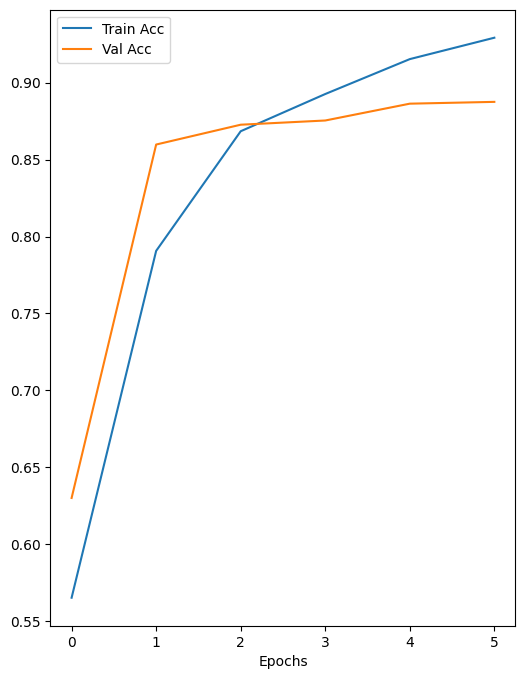

In [53]:
#  Affichage du taux de bonnes prédictions
plt.figure(figsize=(6, 8))
plt.plot(range(history_MLP['epochs']), history_MLP['train_acc'], label='Train Acc')
plt.plot(range(history_MLP['epochs']), history_MLP['val_acc'], label='Val Acc')
plt.xlabel("Epochs")
plt.legend()
plt.show()

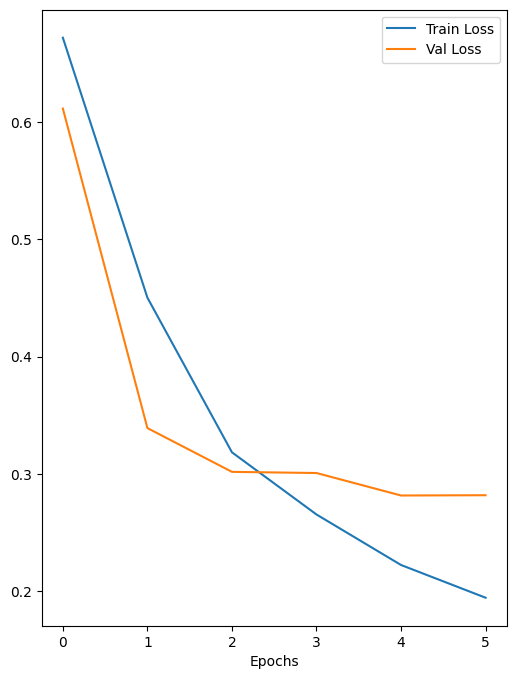

In [54]:
# Affichage de la fonction de perte
plt.figure(figsize=(6, 8))
plt.plot(range(history_MLP['epochs']), history_MLP['train_loss'], label='Train Loss')
plt.plot(range(history_MLP['epochs']), history_MLP['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.legend()
plt.show()

L'accuracy des données d'apprentissage est légèrement supérieure avec le MLP que celle obtenue pour les modèles de LSTM et de GRU. De plus, la loss est légèrement plus faible à la fois pour l'apprentissage et la validation dans le cas d'un MLP. Le MLP semble donc être légèrement plus efficace en terme de classification et a en plus l'avantage d'être beaucoup plus rapidement optimisé (12 minutes pour 15 trials dans l'optimisation bayésienne contre plus de 2h pour les deux réseaux récurrents).

Encore une fois, on observe un début de surapprentissage sur les dernières epochs.

#### CNN

In [32]:
def optim_CNN(trial):
    # Hyperparamètres à tester
    embedding_size = trial.suggest_int('embedding_size', 128, 512)
    n_filters = trial.suggest_int('n_filters', 50, 300)
    filter_sizes = trial.suggest_categorical('filter_sizes', [[3, 4, 5], [3, 5, 7], [2, 3, 4]])
    dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-3)
    batch_size = trial.suggest_int('batch_size', 64, 128)
    epochs = trial.suggest_int('epochs', 5, 15)
    
    model = Modele_CNN(vocab_size, output_size, embedding_size=embedding_size, n_filters=n_filters, filter_sizes=filter_sizes, dropout=dropout).to(device)

    optimizer = Adam(model.parameters(), lr=lr)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for feature, target in train_loader:
            feature, target = feature.to(device), target.to(device)
            optimizer.zero_grad()
            out = model(feature)
            loss = criterion(out.squeeze(), target.float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for feature, target in val_loader:
                feature, target = feature.to(device), target.to(device)
                out = model(feature)
                loss = criterion(out.squeeze(), target.float())
                val_loss += loss.item()

    return val_loss / len(val_loader)

In [33]:
opti_CNN = optuna.create_study(direction='minimize')  # On minimise la perte

opti_CNN.optimize(optim_CNN, n_trials=15)  # Teste 5 configurations différentes

# Afficher les meilleurs hyperparamètres trouvés
print(f"Meilleurs hyperparamètres : {opti_CNN.best_params}")

print(f"Meilleure valeur de la perte : {opti_CNN.best_value}")

[I 2024-12-11 13:54:55,899] A new study created in memory with name: no-name-d4179731-06fd-4078-ac0a-b418dbc3000b
/tmp/ipykernel_58578/2700843627.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipykernel_58578/2700843627.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-3)
[I 2024-12-11 13:55:49,106] Trial 0 finished with value: 0.3330736153505065 and parameters: {'embedding_size': 292, 'n_filters': 124, 'filter_sizes': [2, 3, 4], 'dropout': 0.2601041175849923, 'lr': 0.00010297490623618494, 'batch_size': 115, 'epochs': 6}. Best is trial 0 with value: 0.3330736153505065.
[I 2024-12

Meilleurs hyperparamètres : {'embedding_size': 354, 'n_filters': 98, 'filter_sizes': [2, 3, 4], 'dropout': 0.31131777353883633, 'lr': 0.000101246317923668, 'batch_size': 84, 'epochs': 15}
Meilleure valeur de la perte : 0.2896754463513692


In [36]:
# Crée un modèle final avec les meilleurs hyperparamètres
best_params_CNN = opti_CNN.best_params
best_model_CNN = Modele_CNN(vocab_size, output_size, 
                         embedding_size = best_params_CNN['embedding_size'],
                         n_filters = best_params_CNN['n_filters'],
                         filter_sizes = best_params_CNN['filter_sizes'],
                         dropout = best_params_CNN['dropout']).to(device)

optimizer_CNN = Adam(best_model_CNN.parameters(), lr=best_params_CNN['lr'])
epochs_CNN = best_params_CNN['epochs']

print_every = 1
history_CNN = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epochs': epochs_CNN
}

In [37]:
best_model_CNN = best_model_CNN.to(device)

epochloop = tqdm(range(epochs_CNN), position=0, desc='Training', leave=True)

# early stop trigger
es_trigger = 0
val_loss_min = torch.inf

for e in epochloop:

    #################
    # training mode #
    #################

    best_model_CNN.train()

    train_loss = 0
    train_acc = 0

    for id, (feature, target) in enumerate(train_loader):
        epochloop.set_postfix_str(f'Training batch {id}/{len(train_loader)}')

        feature, target = feature.to(device), target.to(device)

        optimizer_CNN.zero_grad()

        out = best_model_CNN(feature)

        # accuracy
        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        train_acc += acc.item()

        # loss
        loss = criterion(out.squeeze(), target.float())
        train_loss += loss.item()
        loss.backward()

        nn.utils.clip_grad_norm_(best_model_CNN.parameters(), grad_clip)

        optimizer_CNN.step()

        del feature, target, predicted

    history_CNN['train_loss'].append(train_loss / len(train_loader))
    history_CNN['train_acc'].append(train_acc / len(train_loader))

    ####################
    # validation model #
    ####################

    best_model_CNN.eval()

    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for id, (feature, target) in enumerate(val_loader):
            
            epochloop.set_postfix_str(f'Validation batch {id}/{len(val_loader)}')
            
            feature, target = feature.to(device), target.to(device)

            out = best_model_CNN(feature)

            # accuracy
            predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
            equals = predicted == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            val_acc += acc.item()

            # loss
            loss = criterion(out.squeeze(), target.float())
            val_loss += loss.item()

            del feature, target, predicted

        history_CNN['val_loss'].append(val_loss / len(val_loader))
        history_CNN['val_acc'].append(val_acc / len(val_loader))

    best_model_CNN.train()

    epochloop.set_postfix_str(f'Val Loss: {val_loss / len(val_loader):.3f} | Val Acc: {val_acc / len(val_loader):.3f}')

    if (e+1) % print_every == 0:
        epochloop.write(f'Epoch {e+1}/{epochs} | Train Loss: {train_loss / len(train_loader):.3f} Train Acc: {train_acc / len(train_loader):.3f} | Val Loss: {val_loss / len(val_loader):.3f} Val Acc: {val_acc / len(val_loader):.3f}')
        epochloop.update()

    if val_loss / len(val_loader) <= val_loss_min:
        torch.save(best_model_CNN.state_dict(), './sentiment_cnn.pt')
        val_loss_min = val_loss / len(val_loader)
        es_trigger = 0
    else:
        epochloop.write(f'[WARNING] Validation loss did not improved ({val_loss_min:.3f} --> {val_loss / len(val_loader):.3f})')
        es_trigger += 1

    if es_trigger >= es_limit:
        epochloop.write(f'Early stopped at Epoch-{e+1}')
        history_CNN['epochs'] = e+1
        break

Training:   7%|▋         | 1/15 [00:11<02:44, 11.73s/it, Val Loss: 0.506 | Val Acc: 0.765]

Epoch 1/5 | Train Loss: 0.629 Train Acc: 0.634 | Val Loss: 0.506 Val Acc: 0.765


Training:  20%|██        | 3/15 [00:24<01:40,  8.35s/it, Val Loss: 0.433 | Val Acc: 0.801]

Epoch 2/5 | Train Loss: 0.489 Train Acc: 0.765 | Val Loss: 0.433 Val Acc: 0.801


Training:  27%|██▋       | 4/15 [00:37<01:51, 10.12s/it, Val Loss: 0.393 | Val Acc: 0.821]

Epoch 3/5 | Train Loss: 0.429 Train Acc: 0.804 | Val Loss: 0.393 Val Acc: 0.821


Training:  40%|████      | 6/15 [00:50<01:15,  8.43s/it, Val Loss: 0.377 | Val Acc: 0.836]

Epoch 4/5 | Train Loss: 0.388 Train Acc: 0.826 | Val Loss: 0.377 Val Acc: 0.836


Training:  47%|████▋     | 7/15 [01:03<01:18,  9.86s/it, Val Loss: 0.351 | Val Acc: 0.847]

Epoch 5/5 | Train Loss: 0.353 Train Acc: 0.847 | Val Loss: 0.351 Val Acc: 0.847


Training:  53%|█████▎    | 8/15 [01:16<01:15, 10.79s/it, Val Loss: 0.344 | Val Acc: 0.853]

Epoch 6/5 | Train Loss: 0.330 Train Acc: 0.859 | Val Loss: 0.344 Val Acc: 0.853


Training:  67%|██████▋   | 10/15 [01:29<00:44,  8.93s/it, Val Loss: 0.338 | Val Acc: 0.855]

Epoch 7/5 | Train Loss: 0.308 Train Acc: 0.869 | Val Loss: 0.338 Val Acc: 0.855


Training:  73%|███████▎  | 11/15 [01:42<00:40, 10.17s/it, Val Loss: 0.319 | Val Acc: 0.866]

Epoch 8/5 | Train Loss: 0.290 Train Acc: 0.879 | Val Loss: 0.319 Val Acc: 0.866


Training:  80%|████████  | 12/15 [01:55<00:33, 11.06s/it, Val Loss: 0.312 | Val Acc: 0.871]

Epoch 9/5 | Train Loss: 0.270 Train Acc: 0.891 | Val Loss: 0.312 Val Acc: 0.871


Training:  87%|████████▋ | 13/15 [02:08<00:23, 11.64s/it, Val Loss: 0.307 | Val Acc: 0.872]

Epoch 10/5 | Train Loss: 0.257 Train Acc: 0.896 | Val Loss: 0.307 Val Acc: 0.872


Training: 100%|██████████| 15/15 [02:21<00:00,  9.45s/it, Training batch 6/313]            

Epoch 11/5 | Train Loss: 0.245 Train Acc: 0.900 | Val Loss: 0.307 Val Acc: 0.869
[WARNING] Validation loss did not improved (0.307 --> 0.307)


Training: 16it [02:32, 10.01s/it, Val Loss: 0.302 | Val Acc: 0.875]                        

Epoch 12/5 | Train Loss: 0.229 Train Acc: 0.909 | Val Loss: 0.302 Val Acc: 0.875


Training: 17it [02:45, 10.97s/it, Val Loss: 0.295 | Val Acc: 0.877]

Epoch 13/5 | Train Loss: 0.220 Train Acc: 0.913 | Val Loss: 0.295 Val Acc: 0.877


Training: 18it [02:59, 11.66s/it, Training batch 6/313]            

Epoch 14/5 | Train Loss: 0.210 Train Acc: 0.918 | Val Loss: 0.300 Val Acc: 0.876
[WARNING] Validation loss did not improved (0.295 --> 0.300)


Training: 19it [03:10, 11.55s/it, Val Loss: 0.288 | Val Acc: 0.877]

Epoch 15/5 | Train Loss: 0.198 Train Acc: 0.922 | Val Loss: 0.288 Val Acc: 0.877


Training: 100%|██████████| 15/15 [03:12<00:00, 12.80s/it, Val Loss: 0.288 | Val Acc: 0.877]


In [40]:
# Sauvegarder à la fois les poids du modèle et les paramètres optimaux
checkpoint = {
    'model_state_dict': best_model_CNN.state_dict(),
    'best_params': best_params_CNN
}

torch.save(checkpoint, 'best_model_checkpoint_cnn.pth')

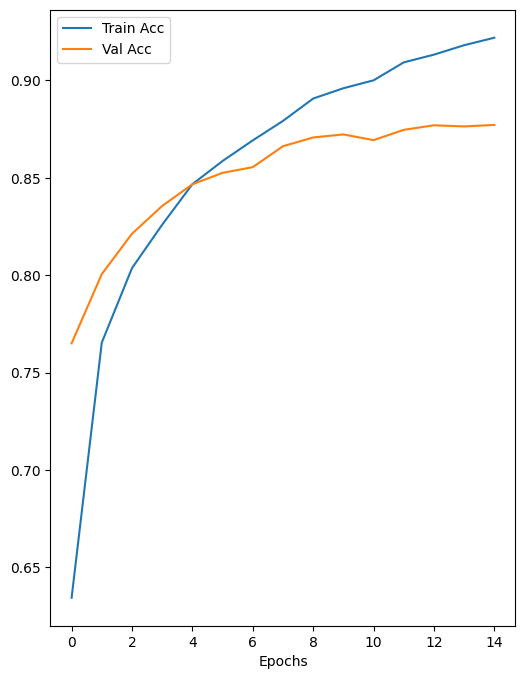

In [38]:
#  Affichage du taux de bonnes prédictions
plt.figure(figsize=(6, 8))
plt.plot(range(history_CNN['epochs']), history_CNN['train_acc'], label='Train Acc')
plt.plot(range(history_CNN['epochs']), history_CNN['val_acc'], label='Val Acc')
plt.xlabel("Epochs")
plt.legend()
plt.show()

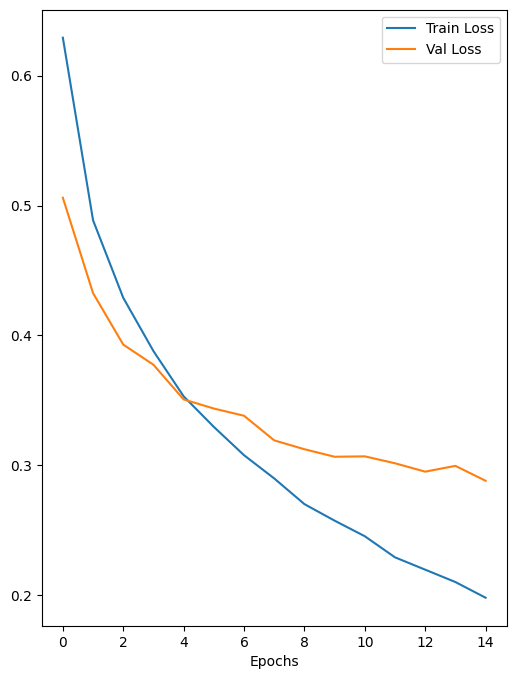

In [39]:
# Affichage de la fonction de perte
plt.figure(figsize=(6, 8))
plt.plot(range(history_CNN['epochs']), history_CNN['train_loss'], label='Train Loss')
plt.plot(range(history_CNN['epochs']), history_CNN['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.legend()
plt.show()

Globalement les performances de l'apprentissage et de la validation sont similaires à celles obtenues avec le modèle de MLP.

# Récupération des modèles sauvegardés

In [32]:
# Charger le checkpoint
checkpoint = torch.load('best_model_checkpoint.pth')

# Récupérer le modèle
best_model_LSTM = Modele_LSTM(vocab_size, output_size, 
                              embedding_size = checkpoint['best_params']['embedding_size'], 
                              hidden_size = checkpoint['best_params']['hidden_size'], 
                              dropout = checkpoint['best_params']['dropout'], 
                              n_layers = checkpoint['best_params']['n_layers'], 
                              dropout_layer = checkpoint['best_params']['dropout_layer']).to(device)

# Charger les poids du modèle
best_model_LSTM.load_state_dict(checkpoint['model_state_dict'])



/tmp/ipykernel_9699/2884075325.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model_checkpoint.pth')


<All keys matched successfully>

In [36]:
# Charger le checkpoint
checkpoint_GRU = torch.load('best_model_checkpoint_gru.pth')

# Récupérer le modèle
best_model_GRU = Modele_GRU(vocab_size, output_size, 
                              embedding_size = checkpoint_GRU['best_params']['embedding_size'], 
                              hidden_size = checkpoint_GRU['best_params']['hidden_size'], 
                              dropout = checkpoint_GRU['best_params']['dropout'], 
                              n_layers = checkpoint_GRU['best_params']['n_layers'], 
                              dropout_layer = checkpoint_GRU['best_params']['dropout_layer']).to(device)

# Charger les poids du modèle
best_model_GRU.load_state_dict(checkpoint_GRU['model_state_dict'])


/tmp/ipykernel_9699/3995053195.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_GRU = torch.load('best_model_checkpoint_gru.pth')


<All keys matched successfully>

In [ ]:
# Charger le checkpoint
checkpoint_CNN= torch.load('best_model_checkpoint_cnn.pth')

# Récupérer le modèle
best_model_CNN = Modele_GRU(vocab_size, output_size, 
                              embedding_size = checkpoint_CNN['best_params']['embedding_size'], 
                              hidden_size = checkpoint_CNN['best_params']['hidden_size'], 
                              dropout = checkpoint_CNN['best_params']['dropout'], 
                              n_layers = checkpoint_CNN['best_params']['n_layers'], 
                              dropout_layer = checkpoint_CNN['best_params']['dropout_layer']).to(device)

# Charger les poids du modèle
best_model_CNN.load_state_dict(checkpoint_CNN['model_state_dict'])

In [40]:
# Charger le checkpoint
checkpoint_MLP = torch.load('best_model_checkpoint_mlp.pth')

# Récupérer le modèle
best_model_MLP = Modele_MLP(vocab_size, output_size, 
                              embedding_size = checkpoint_MLP['best_params']['embedding_size'], 
                              hidden_size = checkpoint_MLP['best_params']['hidden_size'], 
                              dropout = checkpoint_MLP['best_params']['dropout']).to(device)

# Charger les poids du modèle
best_model_MLP.load_state_dict(checkpoint_MLP['model_state_dict'])


/tmp/ipykernel_9699/352667286.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_MLP = torch.load('best_model_checkpoint_mlp.pth')


<All keys matched successfully>

In [41]:
# Charger le checkpoint
checkpoint_CNN = torch.load('best_model_checkpoint_cnn.pth')

# Récupérer le modèle
best_model_CNN = Modele_CNN(vocab_size, output_size, 
                              embedding_size = checkpoint_CNN['best_params']['embedding_size'], 
                              n_filters = checkpoint_CNN['best_params']['n_filters'], 
                              filter_sizes = checkpoint_CNN['best_params']['filter_sizes'],
                              dropout = checkpoint_CNN['best_params']['dropout']).to(device)

# Charger les poids du modèle
best_model_CNN.load_state_dict(checkpoint_CNN['model_state_dict'])

/tmp/ipykernel_9699/3479991597.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_CNN = torch.load('best_model_checkpoint_cnn.pth')


<All keys matched successfully>

# Performances des modèles sur les données test

On voudrait maintenant observer les performances de nos différents modèles sur les données test (c'est-à-dire celles qui n'ont pas été vues pendant l'entraînement) afin d'analyser les capacités de généralisation de nos modèles.

Pour chaque modèle on affiche donc l'accuracy obtenue, la loss ainsi qu'une matrice de confusion.

In [49]:
models = {
    'RNN': best_model_RNN,
    'LSTM': best_model_LSTM,
    'GRU': best_model_GRU,
    'CNN': best_model_CNN,
    'MLP': best_model_MLP
}

In [ ]:
for model in models:
    model.eval()

    test_loss = 0
    test_acc = 0

    all_target = []
    all_predicted = []

    testloop = tqdm(test_loader, leave=True, desc='Inference')
    with torch.no_grad():
        for feature, target in testloop:
            feature, target = feature.to(device), target.to(device)

            out = model(feature)
            
            predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
            equals = predicted == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            test_acc += acc.item()

            loss = criterion(out.squeeze(), target.float())
            test_loss += loss.item()

            all_target.extend(target.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

        print(f'Accuracy: {test_acc/len(test_loader):.4f}, Loss: {test_loss/len(test_loader):.4f}')

    cm = confusion_matrix(all_predicted, all_target)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt='g')
    plt.title('Confusion Matrix')
    plt.show()


MLP Inference: 100%|██████████| 40/40 [00:00<00:00, 193.99it/s]



Metrics for all models:
RNN - Accuracy: 0.5033, Loss: 0.6932
LSTM - Accuracy: 0.8342, Loss: 0.3786
GRU - Accuracy: 0.8592, Loss: 0.3551
CNN - Accuracy: 0.8785, Loss: 0.2889
MLP - Accuracy: 0.8922, Loss: 0.2780


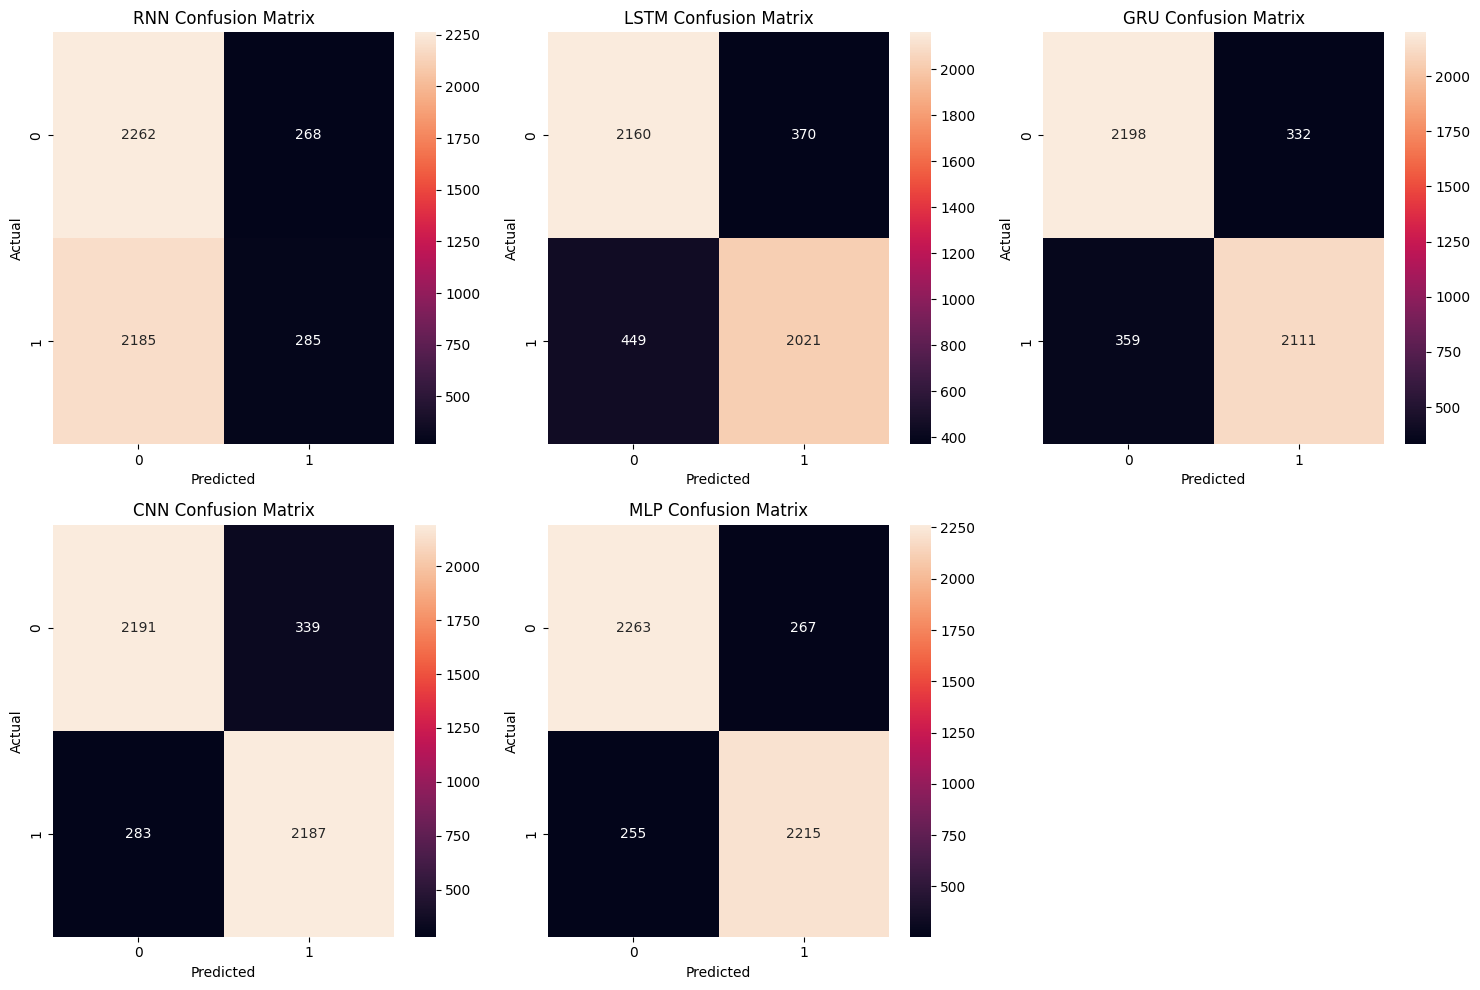

In [50]:
# Dictionnaires pour stocker les métriques
metrics = {}

# Liste pour stocker les matrices de confusion et les noms des modèles
confusion_matrices = []
model_names = []

# Itération sur les modèles
for model_name, model in models.items():
    model.eval()

    test_loss = 0
    test_acc = 0

    all_target = []
    all_predicted = []

    testloop = tqdm(test_loader, leave=True, desc=f'{model_name} Inference')
    with torch.no_grad():
        for feature, target in testloop:
            feature, target = feature.to(device), target.to(device)

            # Prédictions
            out = model(feature)
            predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
            
            # Calcul des métriques
            equals = predicted == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            test_acc += acc.item()

            loss = criterion(out.squeeze(), target.float())
            test_loss += loss.item()

            all_target.extend(target.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

    # Calcul de l'accuracy et la loss moyenne
    accuracy = test_acc / len(test_loader)
    avg_loss = test_loss / len(test_loader)

    # Stocker les métriques dans le dictionnaire
    metrics[model_name] = {'accuracy': accuracy, 'loss': avg_loss}

    # Calcul et stockage de la matrice de confusion
    cm = confusion_matrix(all_target, all_predicted)
    confusion_matrices.append(cm)
    model_names.append(model_name)

# Afficher toutes les métriques à la fin
print("\nMetrics for all models:")
for model_name, metric in metrics.items():
    print(f"{model_name} - Accuracy: {metric['accuracy']:.4f}, Loss: {metric['loss']:.4f}")

# Afficher toutes les matrices de confusion sur deux lignes
fig, axes = plt.subplots(2, len(models) // 2 + len(models) % 2, figsize=(15, 10))  # Disposer les matrices en grille
axes = axes.flatten()  # Aplatir les axes pour indexer facilement

for i, (cm, model_name) in enumerate(zip(confusion_matrices, model_names)):
    sns.heatmap(cm, annot=True, fmt='g', ax=axes[i])
    axes[i].set_title(f'{model_name} Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

# Supprimer les axes inutilisés si le nombre de modèles est impair
if len(models) % 2 != 0:
    for j in range(len(models), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Les résultats obtenus permettent de confirmer les observations faites pendant l'apprentissage : les modèles CNN et MLP sont légèrement plus performants que le LSTM et le GRU, mais globalement les 4 modèles permettent d'obtenir de très bons résultats de prédictions (le surapprentissage mentionné au préalable pour les modèles n'a donc visiblement pas d'impact pour des données non vues). De plus, pour les 4 modèles les mauvaises prédictions sont "équilibrées", c'est-à-dire qu'il y a environ autant d'erreurs faites pour les critiques positives que pour les critiques négatives.

Par ailleurs, on a pu noter plus tôt que le modèle RNN semblait faire des prédictions "aléatoires" (puisqu'on avait environ 50% d'accuracy pendant l'entrainement). On remarque en fait ici que notre modèle prédit pratiquement par la classe 0 (critique négative). Comme le jeu de données est équilibré (50% de critiques positives et 50% négatives) ceci explique les valeurs d'accuracy obtenues plut tôt. Puisque notre modèle prédit presque toujours par la même classe, ceci signfie qu'il n'apprend pas du tout les caractéristiques des textes pendant l'apprentissage.

# Classifieur par ensemble

Pour finir on voudrait créer un classifieur d'ensemble. Le principe est le suivant : pour chaque image de notre jeu de données test, on demande à chaque modèle de réaliser une prédiction. La prédiction finale est ensuite obtenue par vote majoritaire.

In [46]:
class EnsembleClassifier(torch.nn.Module):
    def __init__(self, models):
        super(EnsembleClassifier, self).__init__()
        self.models = models  # Liste des modèles : [RNN, LSTM, GRU, CNN, MLP]
    
    def forward(self, x):
        # Prédictions de chaque modèle
        preds = []
        for model in self.models:
            model.eval()  # Bascule chaque modèle en mode évaluation
            with torch.no_grad():
                output = model(x)
                preds.append(output.squeeze().cpu().numpy())

        preds = np.array(preds)
        final_pred = np.round(np.mean(preds, axis=0))  # Vote majoritaire : seuil à 0.5
        return final_pred


In [47]:
# Taux de bonnes prédictions global

def accuracy_score(y_pred, y_true):
    # y_pred (tensor): Les prédictions du modèle.
    # y_true (tensor): Les véritables étiquettes.
    
    correct = (y_pred == y_true).float()  # comparaison des prédictions et des labels
    accuracy = correct.sum() / len(correct)
    
    return accuracy.item()


In [48]:
# Instanciation du classifieur d'ensemble
ensemble_model = EnsembleClassifier(models=[best_model_RNN, best_model_LSTM, best_model_GRU, best_model_CNN, best_model_MLP])

# Prédictions sur l'ensemble de test
y_true = []  # Liste pour stocker les véritables étiquettes
y_pred = []  # Liste pour stocker les prédictions du classifieur d'ensemble

with torch.no_grad():
    for feature, target in test_loader:
        feature, target = feature.to(device), target.to(device)

        out = ensemble_model(feature)  # Appel direct au modèle pour la prédiction
        y_true.extend(target.cpu().numpy())
        y_pred.extend(out)

# Calcul de la précision
accuracy = accuracy_score(torch.tensor(y_pred), torch.tensor(y_true))

print(f"Accuracy on test set: {accuracy:.4f}")



Accuracy on test set: 0.8902


En utilisant le classifieur d'ensemble on retrouve approximativement le même taux de précision qu'avec le MLP. Le fait d'utiliser le classifieur permet donc de toujours avoir un bon taux de bonnes prédictions mais n'améliore pas spécialement les résultats par rapport au fait de travailler avec les modèles individuels.

Enfin, comme on sait que notre modèle de RNN standard prédit systématiquement par la même classe, on voudrait voir si le fait d'enlever de notre classifieur d'ensemble influence ou non la prédiction.

In [52]:
# Instanciation du classifieur d'ensemble
ensemble_model_without_RNN = EnsembleClassifier(models=[best_model_LSTM, best_model_GRU, best_model_CNN, best_model_MLP])

# Prédictions sur l'ensemble de test
y_true = []  # Liste pour stocker les véritables étiquettes
y_pred = []  # Liste pour stocker les prédictions du classifieur d'ensemble

with torch.no_grad():
    for feature, target in test_loader:
        feature, target = feature.to(device), target.to(device)

        out = ensemble_model_without_RNN(feature)  # Appel direct au modèle pour la prédiction
        y_true.extend(target.cpu().numpy())
        y_pred.extend(out)

# Calcul de la précision
accuracy = accuracy_score(torch.tensor(y_pred), torch.tensor(y_true))

print(f"Accuracy on test set: {accuracy:.4f}")

Accuracy on test set: 0.8906


Travailler avec ou sans le modèle de RNN standard n'influence visiblement pas la performance du classifieur.

# Conclusion

Globalement, le travail effectué a permis de montrer que les modèles de LSTM, de GRU, de CNN et de MLP donnent des performances relativement proches en terme de prédictions. Le MLP et le CNN (dont les performances sont légèrement supérieures) ont par ailleurs l'avantage d'être beaucoup plus rapides à optimiser et semblent donc plus adaptés à notre situation. Globalement, ils permettent d'obtenir un taux de bonnes prédictions proches des 89%.